# Project Objectives and Context:

**Objectives**:
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence).

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also analyze and interpret a model for biases across key demographic groups. 

### Dataset:

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008).

### Data Schema:


# Data Evaluation and Preparation:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp

import aequitas as ae
import functools

from importlib import reload
import functions as fun
reload(fun)

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
import pickle

In [2]:
from sklearn import preprocessing, decomposition

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import recall_score, f1_score, accuracy_score, roc_curve
from sklearn.metrics import precision_score, make_scorer, roc_auc_score

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import XGBClassifier

In [3]:
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload

In [4]:
# OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [5]:
df = pd.read_csv('diabetes_dataset.csv')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [6]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures', 'ndc_code',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted'],
      dtype='object')

In [7]:
df.dtypes

df.shape

(143424, 26)

## Level of EHR Data

It is important to establish whether the dataset is at the line or encounter level. The key fields for this are encounter_id and patient_nbr. Knowing this information will help inform what level of aggregation is necessary for future steps. 

This is commonly overlooked with EHR data.

In [8]:
df.encounter_id.nunique()

101766

In [9]:
df.encounter_id.value_counts()

63415968     6
63184686     6
58316058     6
60016020     6
110310714    6
            ..
59620986     1
11112060     1
94477950     1
103436358    1
396736952    1
Name: encounter_id, Length: 101766, dtype: int64

In [10]:
df.patient_nbr.nunique()

71518

Line level EHR data is the most granular level.  It is a denormalized representation of all things that may happen in a patient encounter.
- For example, could be one row for a new medication, one row for a new diagnosis or a row for a procedure or lab test.

Understanding levels and aggregating EHR data is so important for analysis and modeling!  There may be multiple rows that can be condensed into one patient or one encounter and without understanding this, the data could have a lot of unnecessary noise and create unwanted errors and biases.

In [11]:
fun.test_level(df)

Dataset is probably at the line level.


The encounter_id count is less than the total rows of the dataset, which means that the data is at line level. 
- This means that there may be a lot of missing/null values because one row is not representative of the entire encounter/visit.
- Aggregation will most definitely be needed!

I would like to take a quick look at the unique encounter_id values as well as the unique patient_nbr values so I have an idea of what types of aggregation will be needed.

In [12]:
encounters = df['encounter_id']
encounter_dups = df[encounters.isin(encounters[encounters.duplicated()])]
print(encounter_dups.shape)
encounter_dups.head()

(72680, 26)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO
5,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,68071-1701,None,None,Ch,NO
7,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,35208-001,None,None,Ch,NO
8,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,16729-001,None,None,Ch,NO
9,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,47918-891,None,None,Ch,NO


In [13]:
patients = df['patient_nbr']
patient_dups = df[patients.isin(patients[patients.duplicated()])]
print(patient_dups.shape)
patient_dups.head()

(105643, 26)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO
5,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,68071-1701,None,None,Ch,NO
7,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,35208-001,None,None,Ch,NO
8,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,16729-001,None,None,Ch,NO
9,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,414,411|V45,0,0,0,70,7,21,1,47918-891,None,None,Ch,NO


In [14]:
patient_dups[patient_dups['encounter_id']==76387002]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
29300,76387002,85504905,Caucasian,Female,[40-50),?,1,6,7,9,?,InfectiousDiseases,730,250.81|707,0,0,0,46,9,14,1,47918-902,None,Norm,No,>30


In [15]:
patient_dups[patient_dups['patient_nbr']==80845353]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
49,260166,80845353,Caucasian,Female,[70-80),?,1,1,7,6,?,Family/GeneralPractice,996,999|250.01,0,0,0,27,8,16,0,47918-902,None,None,No,>30
1008,6000072,80845353,Caucasian,Female,[70-80),?,1,1,7,5,?,Family/GeneralPractice,414,250.01|411,0,3,0,54,7,13,0,47918-898,None,None,Ch,>30
27926,73639704,80845353,Caucasian,Female,[80-90),?,1,1,7,4,?,Cardiology,780,E937|E849,0,2,0,45,8,9,0,NaN,None,None,No,NO


In [16]:
df.change.replace({'Ch': 'Yes'}, inplace=True)

df['readmitted_binary'] = df['readmitted']
df.readmitted_binary.replace({'>30': 'Yes', '<30': 'Yes'}, 
                                       inplace=True)
df['readmitted_binary'].value_counts(normalize=True)

NO     0.538599
Yes    0.461401
Name: readmitted_binary, dtype: float64

The two classes we will be predicting (readmission or not) seem pretty equally balanced.

## NDC Codes: 

**NDC codes are a common format to represent the wide variety of drugs that are prescribed in the United States.** 

The challenge is that there are many codes that map to the same or similar drug. 
> - There are crosswalk connections made to assist with this.  They are mappings to connect different code sets or datasets depending on the data being used.
- The National Drug Codes List site: (https://ndclist.com/)
  - Using the NDC lookup tool I will reduce the dimensionality of the NDC code feature.


In [17]:
ndc_code_df = pd.read_csv('ndc_crosswalk')
ndc_code_df.head()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


**To reduce dimensionality:**
> - Join the two datasets on the NDC code columns.  
- Only need the Non-proprietary name column from the NDC data.
    - This is the generic name for the drug.
    - This will reduce dimensionality because there are similiar drugs prescribed to the diabetic patients, but many non-generic names for the same drug **AND** different dosage forms for each drug.
        - Each of these different dosages or non-generic name, etc equate to it's own unique NDC code.

> The importance of understanding these differences (or lack there of), is crucial because, like the diagnosis and encounter data, you could end up with a lot of noise or unnecessary data.

In [18]:
df_original = df.copy()
df_original.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,readmitted_binary
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Yes,>30,Yes
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Yes,NO,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Yes,NO,NO


In [19]:
df = fun.reduce_ndc(df_original, ndc_code_df)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,readmitted_binary,generic_drug
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO,NO,NaN
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Yes,>30,Yes,Human Insulin
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO,NO,Glipizide
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Yes,NO,NO,Human Insulin
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Yes,NO,NO,Glipizide


**To check that the reduction worked:**

- The number of unique values for the new columns should be less than the original columns.

In [20]:
orig_codes = df_original['ndc_code'].nunique() 
reduced_codes = df['generic_drug'].nunique()
print(f'Reduced from {orig_codes} to {reduced_codes}')

df_original['ndc_code'].nunique() > df['generic_drug'].nunique()

Reduced from 251 to 22


True

## Grouping Encounters:

> To simplify the aggregation of data further...
- This is to reduce the risk of data leakage of future patient encounters.
    - Data leakage in EHR data is when patient data is shared across the training and test datasets.  It leads to inaccurate labels and demographics that are not reflective of the real world during modeling.
- This will reduce complexity of the data transformation during modeling steps.

In [21]:
non_grouped_field_list = ['generic_drug', 'ndc_code']
grouping_field_list = [c for c in df.columns if c not in non_grouped_field_list]

In [22]:
grouped_test = df.groupby(grouping_field_list)[non_grouped_field_list].agg(lambda x: 
                        list([y for y in x if y is not np.nan])).reset_index()


In [23]:
grouped_test.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,readmitted_binary,generic_drug,ndc_code
0,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,None,None,Yes,NO,NO,"[Glipizide, Insulin Human]","[0049-4110, 47918-902]"
1,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,None,None,Yes,NO,NO,"[Rosiglitazone Maleate, Human Insulin]","[0173-0863, 68071-1701]"
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,None,None,Yes,NO,NO,"[Glipizide, Human Insulin]","[0049-4110, 68071-1701]"
3,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,None,None,No,>30,Yes,[Human Insulin],[68071-1701]
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,414,411|250,0,0,0,31,9,16,6,None,None,No,>30,Yes,[Insulin Human],[47918-902]


In [24]:
grouped_test[grouped_test['patient_nbr']==80845353]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,readmitted_binary,generic_drug,ndc_code
30,260166,80845353,Caucasian,Female,[70-80),?,1,1,7,6,?,Family/GeneralPractice,996,999|250.01,0,0,0,27,8,16,0,None,None,No,>30,Yes,[Insulin Human],[47918-902]
773,6000072,80845353,Caucasian,Female,[70-80),?,1,1,7,5,?,Family/GeneralPractice,414,250.01|411,0,3,0,54,7,13,0,None,None,Yes,>30,Yes,[Insulin Human],[47918-898]
21041,73639704,80845353,Caucasian,Female,[80-90),?,1,1,7,4,?,Cardiology,780,E937|E849,0,2,0,45,8,9,0,None,None,No,NO,NO,[],[]


In [25]:
patients = grouped_test['patient_nbr']
patient_test = grouped_test[patients.isin(patients[patients.duplicated()])]
print(patient_test.shape)
# patient_test.head()

(47021, 28)


**Checking that each encounter holds different values for a duplicate patient:**

In [26]:
patient_test[patient_test['patient_nbr']==114715242]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,readmitted_binary,generic_drug,ndc_code
31,293058,114715242,Caucasian,Male,[60-70),?,2,6,2,5,?,?,473,996|482,0,0,0,37,8,18,0,None,None,No,>30,Yes,[Insulin Human],[47918-902]
6300,31409370,114715242,Caucasian,Male,[60-70),?,2,6,2,4,?,?,996,486|250,0,2,0,69,5,24,1,None,None,Yes,NO,NO,[Human Insulin],[68071-1701]


> The features that seem to change from encounter to encounter for the same patient are:
- discharge disposition
- time in hospital
- primary diagnosis (and 2nd/3rd)
- number of visits (but still too many zeros)
- number of lab procedures
- number of diagnoses
- number of medications
- number of procedures (but need to check for zeros)
- change in meds
- the ndc_codes - but not necessarily generic medication names (because we grouped/reduced them)

> **- Target feature: readmitted**

**Checking that there are no duplicate encounters:**

In [27]:
encounts = grouped_test['encounter_id']
dup_encounts = grouped_test[encounts.isin(encounts[encounts.duplicated()])]
print(dup_encounts.shape)
dup_encounts.head()


(0, 28)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,readmitted_binary,generic_drug,ndc_code


In [28]:
df[df['patient_nbr']==1766367]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,readmitted_binary,generic_drug
1335,7753584,1766367,Caucasian,Female,[50-60),?,1,1,7,6,?,InternalMedicine,250.13,599|276,0,0,0,68,9,20,1,68071-1701,None,>8,No,NO,NO,Human Insulin


**Encounter level: Total Number of Rows = Number of Unique Encounters**

In [29]:
print(df.encounter_id.nunique())
df.shape[0]

101766


143482

In [30]:
df['readmitted_binary'].value_counts(normalize=True)
# df['readmitted'].value_counts(normalize=True)

NO     0.538632
Yes    0.461368
Name: readmitted_binary, dtype: float64

## Feature Analysis:

In [31]:
df = pd.read_csv('fully_labeled.csv')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,readmitted_binary,generic_drug,ndc_code,second_diagnosis_code,other_diagnosis_code
0,12522,48330783,Caucasian,Female,[80-90),?,Urgent,Home,Transferred,13,?,?,circulatory,0,0,0,68,8,28,2,None,None,Yes,NO,NO,"['Glipizide', 'Insulin Human']","['0049-4110', '47918-902']",circulatory,InfectiousDiseases
1,15738,63555939,Caucasian,Female,[90-100),?,Elective,Transferred,Transferred,12,?,InternalMedicine,circulatory,0,0,0,33,8,18,3,None,None,Yes,NO,NO,"['Rosiglitazone Maleate', 'Human Insulin']","['0173-0863', '68071-1701']",neoplasms,respiratory
2,16680,42519267,Caucasian,Male,[40-50),?,Emergency,Home,EmergencyRoom,1,?,?,neoplasms,0,0,0,51,5,8,0,None,None,Yes,NO,NO,"['Glipizide', 'Human Insulin']","['0049-4110', '68071-1701']",neoplasms,diabetes
3,28236,89869032,AfricanAmerican,Female,[40-50),?,Emergency,Home,EmergencyRoom,9,?,?,diabetes,0,0,0,47,9,17,2,None,None,No,>30,Yes,['Human Insulin'],['68071-1701'],circulatory,injury
4,35754,82637451,Caucasian,Male,[50-60),?,Urgent,Home,Referral,3,?,?,circulatory,0,0,0,31,9,16,6,None,None,No,>30,Yes,['Insulin Human'],['47918-902'],circulatory,diabetes


### Target PCA:

In [32]:
# import patsy
# %pylab inline



# %config InlineBackend.figure_format = 'svg'
# sns.set_style("white")

In [33]:
# collist = list(df.columns)
# collist.remove('readmitted')
# collist.remove('readmitted_binary')
# collist.remove('encounter_id')
# collist.remove('patient_nbr')
# patsy_x_string = (' + ').join(collist)
# patsy_x_string

In [34]:
# y, x = patsy.dmatrices(f'readmitted ~ {patsy_x_string}', 
#                        data=df, return_type="dataframe")

In [35]:
# y = df.readmitted
# numeric_pca_columns = list(df.select_dtypes("int64").columns)
# numeric_pca_columns.remove('encounter_id')
# numeric_pca_columns.remove('patient_nbr')
# numeric_pca_columns

In [36]:
# pca_scaler = preprocessing.StandardScaler()
# x_scaled = x.copy()
# x_scaled = pca_scaler.fit_transform(x_scaled[numeric_pca_columns])
# # scaling because PCA is distance-based
# x = x_scaled

In [37]:
# # Make binary
# y_num = y.copy()
# y_num = y_num.replace('>30', 1)
# y_num = y_num.replace('<30',1)
# y_num = y_num.replace('NO',0)
# y_num.value_counts(normalize=True)

In [38]:
# # label
# y = y.str.replace('NO','Not Readmitted')
# y = y.str.replace('<30','Readmission')
# y = y.str.replace('>30','Readmission')

# y_colors = ['purple', 'yellow']

In [39]:
# fun.plot_PCA_2D(x_scaled, y_num, y.unique(), y_colors)

> Not easily separatable.

To start my analysis into the features of this dataset, I will go ahead and distinguish between the categorical columns and the numerical columns.

In [40]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id           object
discharge_disposition_id    object
admission_source_id         object
time_in_hospital             int64
payer_code                  object
medical_specialty           object
primary_diagnosis_code      object
number_outpatient            int64
number_inpatient             int64
number_emergency             int64
num_lab_procedures           int64
number_diagnoses             int64
num_medications              int64
num_procedures               int64
max_glu_serum               object
A1Cresult                   object
change                      object
readmitted                  object
readmitted_binary           object
generic_drug                object
ndc_code                    object
second_diagnosis_code       object
other_diagnosis_code

In [41]:
cat_cols = df.select_dtypes(include=['O'])
num_cols = df.select_dtypes(exclude=['O'])
print(f'The categorical columns are: \n{list(cat_cols.columns)}\n')
print(f'The numeric columns are: \n{list(num_cols.columns)}')

The categorical columns are: 
['race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'payer_code', 'medical_specialty', 'primary_diagnosis_code', 'max_glu_serum', 'A1Cresult', 'change', 'readmitted', 'readmitted_binary', 'generic_drug', 'ndc_code', 'second_diagnosis_code', 'other_diagnosis_code']

The numeric columns are: 
['encounter_id', 'patient_nbr', 'time_in_hospital', 'number_outpatient', 'number_inpatient', 'number_emergency', 'num_lab_procedures', 'number_diagnoses', 'num_medications', 'num_procedures']


### Null and Placeholder Values:

Check for null values.

In [42]:
fun.missing_data(df)

,Total,Percent


No missing values.

In [43]:
df_placeholders, df_cardinality = fun.get_null_get_cardinality(df, cat_cols)

In [44]:
df.shape

(101766, 29)

In [45]:
df_placeholders

,columns,placeholder,total_placeholders
0,race,?,2273
1,gender,Unknown/Invalid,3
2,age,,0
3,weight,?,98569
4,admission_type_id,,0
5,discharge_disposition_id,,0
6,admission_source_id,,0
7,payer_code,?,40256
8,medical_specialty,?,49949
9,primary_diagnosis_code,,0


> Observations:

- Weight = Most of this column is missing!
- A1 test and glucose test have a lot of 'None' values (meaning no test taken)
- payer_code and medical_specialty are high (not planning on using those though)

In [46]:
df.loc[df['gender']=='Unknown/Invalid']

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,readmitted_binary,generic_drug,ndc_code,second_diagnosis_code,other_diagnosis_code
30506,98634858,100695042,Other,Unknown/Invalid,[70-80),?,Elective,Home,Referral,1,?,Cardiology,circulatory,0,0,0,5,4,22,5,None,None,Yes,NO,NO,"['Glipizide', 'Pioglitazone']","['0591-0460', '0093-7272']",circulatory,circulatory
75551,226864668,60524946,?,Unknown/Invalid,[60-70),?,Emergency,Home,EmergencyRoom,1,CP,?,injury,0,0,0,38,5,6,1,None,None,No,NO,NO,[],[],injury,Other
82573,257364294,78119847,?,Unknown/Invalid,[70-80),?,Emergency,Transferred,EmergencyRoom,8,CP,?,injury,0,0,0,59,9,21,2,None,None,Yes,NO,NO,"['Metformin Hydrochloride', 'Rosiglitazone Mal...","['0615-7982', '0173-0861']",injury,injury


I am going to drop the three encounters with unknown gender values because they did not result in readmissions so I am not concerned that we are losing pertinent information.

In [47]:
df.drop([30506, 75551, 82573], axis=0, inplace=True)

### Cardinality in Categorical Features:

I can check for high cardinality in the categorical features with the loop above.

In [48]:
df_cardinality

,columns,total_unique,unique_values
0,race,6,"[Caucasian, AfricanAmerican, ?, Other, Asian, ..."
1,gender,3,"[Female, Male, Unknown/Invalid]"
2,age,10,"[[80-90), [90-100), [40-50), [50-60), [60-70),..."
3,weight,10,"[?, [75-100), [50-75), [0-25), [100-125), [25-..."
4,admission_type_id,7,"[Urgent, Elective, Emergency, Unknown, Newborn..."
5,discharge_disposition_id,12,"[Home, Transferred, HomeHealth, Expired_Inpati..."
6,admission_source_id,8,"[Transferred, EmergencyRoom, Referral, Unknown..."
7,payer_code,18,"[?, MC, MD, HM, UN, BC, SP, CP, SI, DM, CM, CH..."
8,medical_specialty,73,"[?, InternalMedicine, Family/GeneralPractice, ..."
9,primary_diagnosis_code,19,"[circulatory, neoplasms, diabetes, respiratory..."


In [49]:
df_cardinality[df_cardinality.total_unique > 20]

,columns,total_unique,unique_values
8,medical_specialty,73,"[?, InternalMedicine, Family/GeneralPractice, ..."
15,generic_drug,493,"[['Glipizide', 'Insulin Human'], ['Rosiglitazo..."
16,ndc_code,10544,"[['0049-4110', '47918-902'], ['0173-0863', '68..."


> **Observations of features with high cardinality (>20 unique values):**

- medical_specialty (73) - various medical providers (specializing in large number of different fields)
    - Many overlap in speciality.

- ndc_code (10544) - There is a **wide** variety of codes for similiar medications. 
    - Each non-generic name gets a unique code as well as the different dosages of each medication.
    - We have already reduced the dimension by mapping the generic medication name to the ndc codes.
    
- generic_drug (493) - This is only because of the variations - I will one hot encode these.


> **These features having high cardinality is not a surprise and just adds more evidence to the importance of understanding the data!**

### Numerical Feature Distributions:

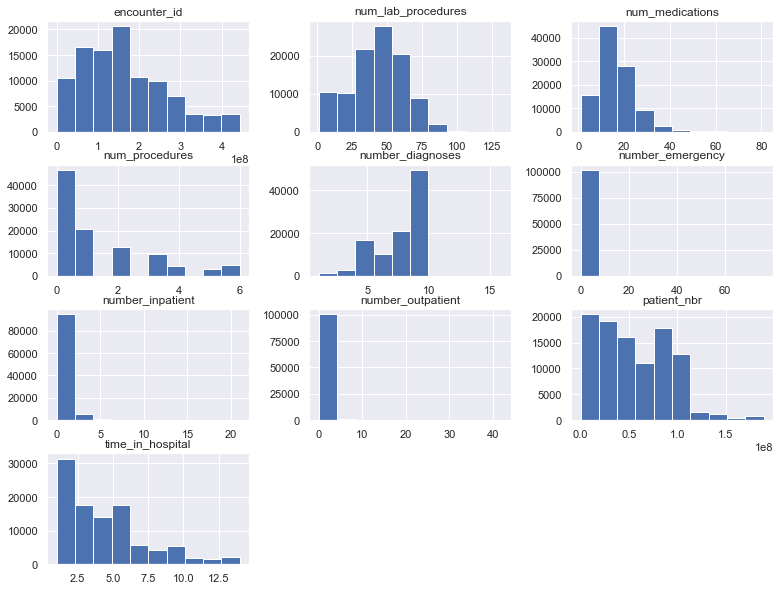

In [50]:
df.hist(figsize=(13,10))
plt.show()

> After evaluating frequency histograms of the numerical columns, it is worth noting that the categories num_lab_procedures and num_medications seem to follow a normal distribution.

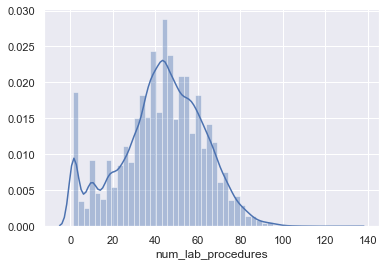

In [51]:
sns.distplot(df.num_lab_procedures)
plt.show()

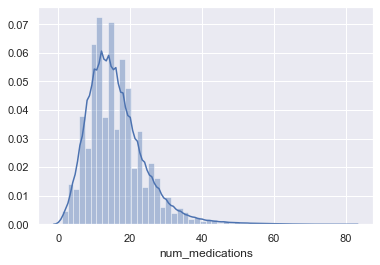

In [52]:
sns.distplot(df.num_medications)
plt.show()

### Patient Demographic Feature Distributions:

> The age feature is bucketed into 10 year groups.

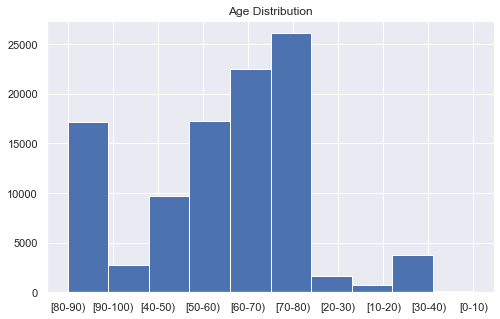

In [53]:
df.age.hist(figsize=(8, 5))
plt.title('Age Distribution')
plt.show()

I am going to switch age to the median age of each bucketed range.

In [54]:
df.age.replace({'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, 
                '[40-50)': 45, '[50-60)': 55,
       '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95}, 
               inplace=True)

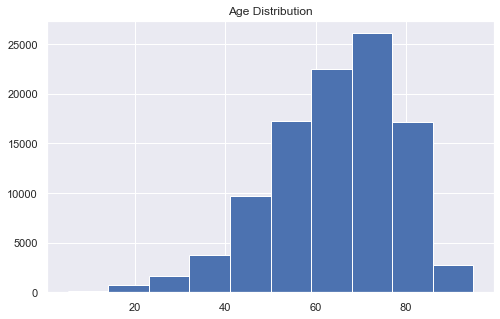

In [55]:
df.age.hist(figsize=(8, 5))
plt.title('Age Distribution')
plt.show()

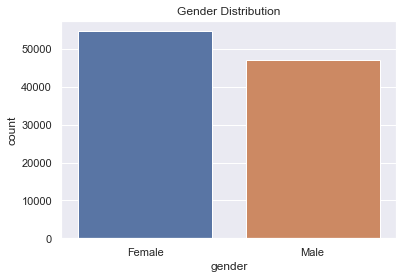

In [56]:
sns.countplot(x="gender", data=df)
plt.title('Gender Distribution')
plt.show()

> **Observations:**

> There are more female patients than male as shown in the gender distribution, but not by much.  I believe this is an insignificant difference.
> - This lines with my assumption that females are generally more likely to seek medical help than males.
    
> The 50-90 age range is highly represented in this dataset.
> - This makes sense with my assumption that younger patients tend to be "more healthy" than older aged patients.

In [57]:
first_list = []

for val in df['generic_drug']:
    first_list.append(val.replace('[', '').replace(']', '').replace("'", '').split(',')[0])
        


df['generic_drug_name'] = first_list


# df.drop(['other_diagnosis_codes'], axis=1, inplace=True)

In [58]:
df.shape

(101763, 30)

## Aggregate for Modeling:

To ensure that the data is on the correct EHR data level, we need to aggregate columns and build the dataset at the appropriate level.

I will transform the dataset using the 'generic_drug' feature.  Then create dummy columns for each unique generic drug name as added engineered features. 

In [59]:
# list columns to use for grouping
groups = [col for col in df.columns if col != 'generic_drug_name']

In [60]:
agg_df, agg_drug_cols = fun.aggregate_dataset(df=df, group_list=groups,
                                         array_field='generic_drug_name')

In [61]:
agg_df.drop([''], axis=1, inplace=True)

In [62]:
agg_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,readmitted_binary,generic_drug,ndc_code,second_diagnosis_code,other_diagnosis_code,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,12522,48330783,Caucasian,Female,85,?,Urgent,Home,Transferred,13,?,?,circulatory,0,0,0,68,8,28,2,None,None,Yes,NO,NO,"['Glipizide', 'Insulin Human']","['0049-4110', '47918-902']",circulatory,InfectiousDiseases,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15738,63555939,Caucasian,Female,95,?,Elective,Transferred,Transferred,12,?,InternalMedicine,circulatory,0,0,0,33,8,18,3,None,None,Yes,NO,NO,"['Rosiglitazone Maleate', 'Human Insulin']","['0173-0863', '68071-1701']",neoplasms,respiratory,[Rosiglitazone Maleate],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,16680,42519267,Caucasian,Male,45,?,Emergency,Home,EmergencyRoom,1,?,?,neoplasms,0,0,0,51,5,8,0,None,None,Yes,NO,NO,"['Glipizide', 'Human Insulin']","['0049-4110', '68071-1701']",neoplasms,diabetes,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,28236,89869032,AfricanAmerican,Female,45,?,Emergency,Home,EmergencyRoom,9,?,?,diabetes,0,0,0,47,9,17,2,None,None,No,>30,Yes,['Human Insulin'],['68071-1701'],circulatory,injury,[Human Insulin],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,35754,82637451,Caucasian,Male,55,?,Urgent,Home,Referral,3,?,?,circulatory,0,0,0,31,9,16,6,None,None,No,>30,Yes,['Insulin Human'],['47918-902'],circulatory,diabetes,[Insulin Human],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [63]:
del agg_drug_cols[0]

In [64]:
agg_drug_cols

['Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glipizide_And_Metformin_Hcl',
 'Glipizide_And_Metformin_Hydrochloride',
 'Glyburide',
 'Glyburide_And_Metformin_Hydrochloride',
 'Glyburide-metformin_Hydrochloride',
 'Human_Insulin',
 'Insulin_Human',
 'Metformin_Hcl',
 'Metformin_Hydrochloride',
 'Miglitol',
 'Nateglinide',
 'Pioglitazone',
 'Pioglitazone_Hydrochloride_And_Glimepiride',
 'Repaglinide',
 'Rosiglitazone_Maleate',
 'Tolazamide',
 'Tolbutamide']

To test the aggregation:

- The row count should be the same as the unique encounter.

In [65]:
len(agg_df) == agg_df['encounter_id'].nunique()

True

## Feature Selection and Preprocessing:

### Feature Selection

For feature selection:

- Look again at numerical column distributions.
- Evaluate percentage of values across columns.

Create seperate lists for chosen categorical and numeric features for subsets.

In [66]:
agg_df.number_diagnoses.value_counts(normalize=True)

9     0.486159
5     0.111946
8     0.104321
7     0.102129
6     0.099850
4     0.054401
3     0.027859
2     0.010053
1     0.002152
16    0.000442
10    0.000167
13    0.000157
11    0.000108
15    0.000098
12    0.000088
14    0.000069
Name: number_diagnoses, dtype: float64

In [67]:
num_cols = agg_df.select_dtypes(exclude='O')
cat_cols = agg_df.select_dtypes(include='O')

In [68]:
agg_df.time_in_hospital.value_counts(normalize=True)

3     0.174484
2     0.169256
1     0.139599
4     0.136828
5     0.097933
6     0.074084
7     0.057575
8     0.043139
9     0.029500
10    0.023014
11    0.018229
12    0.014229
13    0.011890
14    0.010239
Name: time_in_hospital, dtype: float64

In [69]:
agg_df['readmitted_binary'].value_counts(normalize=True)

NO     0.539106
Yes    0.460894
Name: readmitted_binary, dtype: float64

In [70]:
agg_df.change.value_counts(normalize=True)

No     0.538054
Yes    0.461946
Name: change, dtype: float64

In [71]:
agg_df.max_glu_serum.value_counts(normalize=True)

None    0.947466
Norm    0.025520
>200    0.014593
>300    0.012421
Name: max_glu_serum, dtype: float64

In [72]:
agg_df.A1Cresult.value_counts(normalize=True)

None    0.832768
>8      0.080737
Norm    0.049036
>7      0.037460
Name: A1Cresult, dtype: float64

In [73]:
agg_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,readmitted_binary,generic_drug,ndc_code,second_diagnosis_code,other_diagnosis_code,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,12522,48330783,Caucasian,Female,85,?,Urgent,Home,Transferred,13,?,?,circulatory,0,0,0,68,8,28,2,None,None,Yes,NO,NO,"['Glipizide', 'Insulin Human']","['0049-4110', '47918-902']",circulatory,InfectiousDiseases,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15738,63555939,Caucasian,Female,95,?,Elective,Transferred,Transferred,12,?,InternalMedicine,circulatory,0,0,0,33,8,18,3,None,None,Yes,NO,NO,"['Rosiglitazone Maleate', 'Human Insulin']","['0173-0863', '68071-1701']",neoplasms,respiratory,[Rosiglitazone Maleate],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,16680,42519267,Caucasian,Male,45,?,Emergency,Home,EmergencyRoom,1,?,?,neoplasms,0,0,0,51,5,8,0,None,None,Yes,NO,NO,"['Glipizide', 'Human Insulin']","['0049-4110', '68071-1701']",neoplasms,diabetes,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,28236,89869032,AfricanAmerican,Female,45,?,Emergency,Home,EmergencyRoom,9,?,?,diabetes,0,0,0,47,9,17,2,None,None,No,>30,Yes,['Human Insulin'],['68071-1701'],circulatory,injury,[Human Insulin],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,35754,82637451,Caucasian,Male,55,?,Urgent,Home,Referral,3,?,?,circulatory,0,0,0,31,9,16,6,None,None,No,>30,Yes,['Insulin Human'],['47918-902'],circulatory,diabetes,[Insulin Human],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [74]:
agg_df.readmitted_binary.replace({'NO':0, 'Yes':1}, inplace=True)

In [75]:
agg_df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'number_outpatient', 'number_inpatient',
       'number_emergency', 'num_lab_procedures', 'number_diagnoses',
       'num_medications', 'num_procedures', 'max_glu_serum', 'A1Cresult',
       'change', 'readmitted', 'readmitted_binary', 'generic_drug', 'ndc_code',
       'second_diagnosis_code', 'other_diagnosis_code',
       'generic_drug_name_array', 'Acarbose', 'Glimepiride', 'Glipizide',
       'Glipizide_And_Metformin_Hcl', 'Glipizide_And_Metformin_Hydrochloride',
       'Glyburide', 'Glyburide_And_Metformin_Hydrochloride',
       'Glyburide-metformin_Hydrochloride', 'Human_Insulin', 'Insulin_Human',
       'Metformin_Hcl', 'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide',
       'Pioglitazone', 'Pioglitazone_Hydrochloride_And_Glimepir

I have decided on the following features for modeling:

In [76]:
num_feats = ['age', 'num_lab_procedures', 'num_medications', 
             'time_in_hospital',
            'number_diagnoses']  + agg_drug_cols
cat_feats = ['race', 'gender', 'primary_diagnosis_code', 
             'discharge_disposition_id',
                     'second_diagnosis_code', 'other_diagnosis_code',   
             'change']
TARGET = 'readmitted_binary'

In [77]:
feats_df = fun.select_features(agg_df, cat_feats, num_feats, TARGET)
feats_df

,encounter_id,readmitted_binary,race,gender,primary_diagnosis_code,discharge_disposition_id,second_diagnosis_code,other_diagnosis_code,change,age,num_lab_procedures,num_medications,time_in_hospital,number_diagnoses,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,12522,0,Caucasian,Female,circulatory,Home,circulatory,InfectiousDiseases,Yes,85,68,28,13,8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15738,0,Caucasian,Female,circulatory,Transferred,neoplasms,respiratory,Yes,95,33,18,12,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,16680,0,Caucasian,Male,neoplasms,Home,neoplasms,diabetes,Yes,45,51,8,1,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,28236,1,AfricanAmerican,Female,diabetes,Home,circulatory,injury,No,45,47,17,9,9,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,35754,1,Caucasian,Male,circulatory,Home,circulatory,diabetes,No,55,31,16,3,9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101758,443847548,1,AfricanAmerican,Male,diabetes,Transferred,MentalDisorders,circulatory,Yes,75,51,16,3,9,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
101759,443847782,0,AfricanAmerican,Female,digestive,Transferred,Endocrine,digestive,No,85,33,18,5,9,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
101760,443854148,0,Caucasian,Male,InfectiousDiseases,Home,genitourinary,MentalDisorders,Yes,75,53,9,1,13,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
101761,443857166,0,Caucasian,Female,injury,Transferred,BloodDiseases,injury,Yes,85,45,21,10,9,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [78]:
feats_df.dtypes

encounter_id                                   int64
readmitted_binary                              int64
race                                          object
gender                                        object
primary_diagnosis_code                        object
discharge_disposition_id                      object
second_diagnosis_code                         object
other_diagnosis_code                          object
change                                        object
age                                            int64
num_lab_procedures                             int64
num_medications                                int64
time_in_hospital                               int64
number_diagnoses                               int64
Acarbose                                       uint8
Glimepiride                                    uint8
Glipizide                                      uint8
Glipizide_And_Metformin_Hcl                    uint8
Glipizide_And_Metformin_Hydrochloride         

### Preprocessing - Casting:

In [79]:
def update_dtypes(df, categorical_col_list, predictor):
    df[predictor] = df[predictor].astype(float)
    for col in categorical_col_list:
        df[col] = df[col].astype('str')
    return df

In [80]:
processed_df = update_dtypes(feats_df, cat_feats, TARGET)

In [81]:
processed_df.head()

,encounter_id,readmitted_binary,race,gender,primary_diagnosis_code,discharge_disposition_id,second_diagnosis_code,other_diagnosis_code,change,age,num_lab_procedures,num_medications,time_in_hospital,number_diagnoses,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,12522,0.0,Caucasian,Female,circulatory,Home,circulatory,InfectiousDiseases,Yes,85,68,28,13,8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15738,0.0,Caucasian,Female,circulatory,Transferred,neoplasms,respiratory,Yes,95,33,18,12,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,16680,0.0,Caucasian,Male,neoplasms,Home,neoplasms,diabetes,Yes,45,51,8,1,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,28236,1.0,AfricanAmerican,Female,diabetes,Home,circulatory,injury,No,45,47,17,9,9,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,35754,1.0,Caucasian,Male,circulatory,Home,circulatory,diabetes,No,55,31,16,3,9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [82]:
processed_df.dtypes

encounter_id                                    int64
readmitted_binary                             float64
race                                           object
gender                                         object
primary_diagnosis_code                         object
discharge_disposition_id                       object
second_diagnosis_code                          object
other_diagnosis_code                           object
change                                         object
age                                             int64
num_lab_procedures                              int64
num_medications                                 int64
time_in_hospital                                int64
number_diagnoses                                int64
Acarbose                                        uint8
Glimepiride                                     uint8
Glipizide                                       uint8
Glipizide_And_Metformin_Hcl                     uint8
Glipizide_And_Metformin_Hydr

In [83]:
# processed_df.to_csv('processed.csv', index=False)

## Train, Validation, and Test Splits:

For a deep learning model, the data needs to be split into three subsets.

- The validation set = used for optimizing the model's hyperparameters during training 
- 60%/20%/20% train/validation/test split
- Randomly sample different patients from each split.

**IMPORTANT** Make sure that a patient's data is not in more than one set!
   - Avoid possible data leakage

In [84]:
train, test = train_test_split(processed_df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

65128 train examples
16282 validation examples
20353 test examples


In [85]:
len(train) + len(val) + len(test) == len(processed_df)
# print("Test passed for number of total rows equal!")

True

In [86]:
(train['encounter_id'].nunique() + val['encounter_id'].nunique() + test['encounter_id'].nunique()) == agg_df['encounter_id'].nunique()
# print("Test passed for number of unique patients being equal!")

True

To test against accidental patient data leakage:
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset.
- Total number of rows in original dataset = sum of rows across all three splits.

## Feature Representation Across Splits:

After splitting EHR data, it's wise to check the distribution of features and demographics to ensure that the groups are represented appropriately across the train, test and validations splits. 

I created a visualization function that shows how these groups are distributed.

### Target Distribution:

I will evaluate the distributution of the label across the splits. I am looking for similiar distribution shapes across partitions.

Data before splits: 

readmitted_binary
0.0    54861
1.0    46902
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


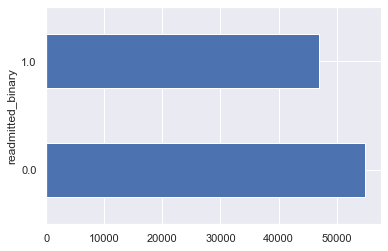

In [87]:
print('Data before splits: \n')
fun.demo_plots(processed_df, TARGET)

Training data: 

readmitted_binary
0.0    35005
1.0    30123
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


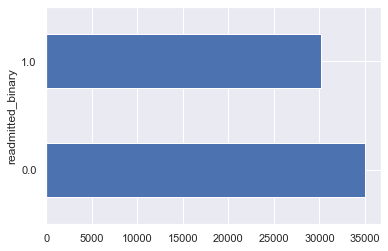

In [88]:
print('Training data: \n')
fun.demo_plots(train, TARGET)

Testing data: 

readmitted_binary
0.0    10982
1.0     9371
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


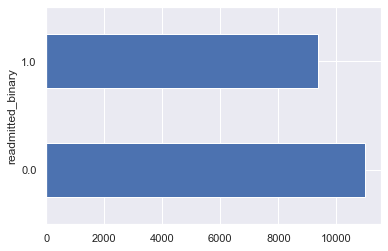

In [89]:
print('Testing data: \n')
fun.demo_plots(test, TARGET)

### Patient Demographic Distributions:

I will check that my splits are similar in terms of the patient demographic representations. 

I can use the same function as above to visualize and analyze the full dataset vs. the splits.

Data before splits: 

gender
Female    54708
Male      47055
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


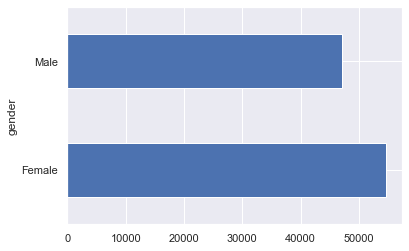

In [90]:
pt_demo_feats = ['race', 'gender', 'age', 'encounter_id']
pt_demo_df = processed_df[pt_demo_feats].groupby('encounter_id').head(1)
pt_demo_df.reset_index(drop=True, inplace=True)

print('Data before splits: \n')
fun.demo_plots(pt_demo_df, 'gender')

Data before splits: 

age
5       161
15      691
25     1657
35     3775
45     9685
55    17256
65    22482
75    26066
85    17197
95     2793
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


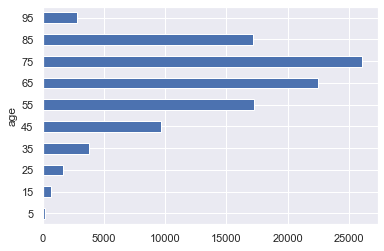

In [91]:
print('Data before splits: \n')
fun.demo_plots(pt_demo_df, 'age')

Training split: 

gender
Female    34879
Male      30249
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


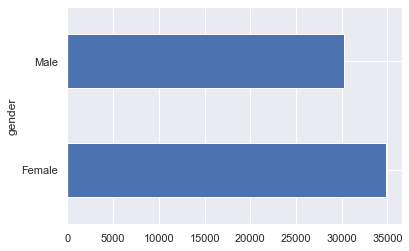

In [92]:
print('Training split: \n')
fun.demo_plots(train, 'gender')

Training split: 

age
5       100
15      437
25     1067
35     2410
45     6199
55    11068
65    14425
75    16643
85    10972
95     1807
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


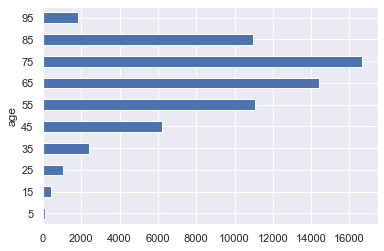

In [93]:
print('Training split: \n')
fun.demo_plots(train, 'age')

Training split: 

gender
Female    10993
Male       9360
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


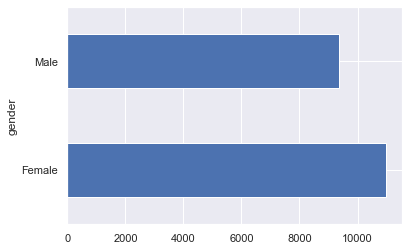

In [94]:
print('Training split: \n')
fun.demo_plots(test, 'gender')

Training split: 

age
5       32
15     149
25     328
35     757
45    1918
55    3415
65    4461
75    5207
85    3521
95     565
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


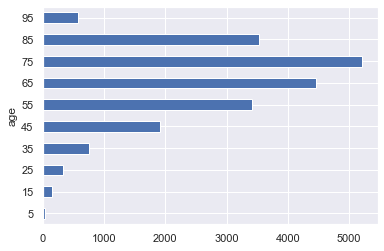

In [95]:
print('Training split: \n')
fun.demo_plots(test, 'age')

Great!  These look pretty similiar and should be representative of all patient groups and data.

# Modeling:

## Scikit Learn Models:

In [113]:
processed_df.drop([ 'Glyburide_And_Metformin_Hydrochloride',
      'Insulin_Human',
       'Metformin_Hcl', 
      'Pioglitazone_Hydrochloride_And_Glimepiride'], axis=1, inplace=True)

In [169]:
processed_df.to_csv('processed.csv', index=False)

In [114]:
X = processed_df.drop(['readmitted_binary', 'encounter_id'], axis=1)
y = processed_df['readmitted_binary']
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.2,
                                                    random_state=42)

X_train.shape[0], X_test.shape[0]

y_train.shape[0], y_test.shape[0]

(81410, 20353)

In [115]:
X_train

,race,gender,primary_diagnosis_code,discharge_disposition_id,second_diagnosis_code,other_diagnosis_code,change,age,num_lab_procedures,num_medications,time_in_hospital,number_diagnoses,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide-metformin_Hydrochloride,Human_Insulin,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
41510,Caucasian,Male,injury,Transferred,Other,circulatory,Yes,75,38,27,2,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
24079,Caucasian,Female,Endocrine,Home,circulatory,circulatory,No,75,48,11,4,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
91367,AfricanAmerican,Female,diabetes,Home,digestive,NervousSystemDiseases,No,45,28,15,2,9,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6237,Caucasian,Male,genitourinary,Home,genitourinary,genitourinary,No,85,44,10,4,7,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
72207,Caucasian,Male,NervousSystemDiseases,Transferred,MentalDisorders,NervousSystemDiseases,Yes,85,54,8,3,8,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,Caucasian,Male,respiratory,Home,circulatory,circulatory,No,75,35,12,2,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
54886,Caucasian,Female,respiratory,Home,respiratory,circulatory,Yes,65,42,18,4,9,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
76820,Caucasian,Female,neoplasms,Transferred,circulatory,circulatory,Yes,95,30,16,4,6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
860,Caucasian,Female,respiratory,Unknown,respiratory,genitourinary,Yes,65,77,21,12,9,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [117]:
# X_test

In [120]:
categorical_features = X_train.select_dtypes('O').columns
numerical_features = X_train.select_dtypes(exclude='O').columns

In [122]:
num_pipe = Pipeline([
    ('scaler', 
    StandardScaler())])

cat_pipe = Pipeline([
    ('encoder',
        OneHotEncoder(sparse=False))])

preprocessing = ColumnTransformer(transformers=[
    ('num', num_pipe, numerical_features),
    ('cat', cat_pipe, categorical_features)])
preprocessing

X_train_trans_one = preprocessing.fit_transform(X_train)
X_test_trans_one = preprocessing.transform(X_test)

feature_names = preprocessing.named_transformers_['cat'].\
                named_steps['encoder'].get_feature_names(categorical_features).tolist()

numerical_features = numerical_features.tolist()
X_cols = numerical_features + feature_names
X_train = pd.DataFrame(X_train_trans_one,columns=X_cols)
X_test = pd.DataFrame(X_test_trans_one,columns=X_cols)
X_train.head()

,age,num_lab_procedures,num_medications,time_in_hospital,number_diagnoses,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide-metformin_Hydrochloride,Human_Insulin,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,race_?,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,primary_diagnosis_code_BloodDiseases,primary_diagnosis_code_CongenitalAnomalies,primary_diagnosis_code_DeliveryComplications,primary_diagnosis_code_Endocrine,primary_diagnosis_code_InfectiousDiseases,primary_diagnosis_code_MentalDisorders,primary_diagnosis_code_NervousSystemDiseases,primary_diagnosis_code_Other,primary_diagnosis_code_SenseOrganDiseases,primary_diagnosis_code_SkinDiseases,primary_diagnosis_code_UnknownSymptoms,primary_diagnosis_code_circulatory,primary_diagnosis_code_diabetes,primary_diagnosis_code_digestive,primary_diagnosis_code_genitourinary,primary_diagnosis_code_injury,primary_diagnosis_code_musculoskeletal,primary_diagnosis_code_neoplasms,primary_diagnosis_code_respiratory,discharge_disposition_id_AMA,discharge_disposition_id_Admitted/Outpatient,discharge_disposition_id_Expired_Elsewhere,discharge_disposition_id_Expired_Inpatient,discharge_disposition_id_Home,discharge_disposition_id_HomeHealth,discharge_disposition_id_Hospice,discharge_disposition_id_NeonatalDischarge,discharge_disposition_id_Transferred,discharge_disposition_id_TransferredMedicare,discharge_disposition_id_TransferredToOutpatient,discharge_disposition_id_Unknown,second_diagnosis_code_BloodDiseases,second_diagnosis_code_CongenitalAnomalies,second_diagnosis_code_DeliveryComplications,second_diagnosis_code_Endocrine,second_diagnosis_code_InfectiousDiseases,second_diagnosis_code_MentalDisorders,second_diagnosis_code_NervousSystemDiseases,second_diagnosis_code_Other,second_diagnosis_code_SenseOrganDiseases,second_diagnosis_code_SkinDiseases,second_diagnosis_code_UnknownSymptoms,second_diagnosis_code_circulatory,second_diagnosis_code_diabetes,second_diagnosis_code_digestive,second_diagnosis_code_genitourinary,second_diagnosis_code_injury,second_diagnosis_code_musculoskeletal,second_diagnosis_code_neoplasms,second_diagnosis_code_respiratory,other_diagnosis_code_BloodDiseases,other_diagnosis_code_CongenitalAnomalies,other_diagnosis_code_DeliveryComplications,other_diagnosis_code_Endocrine,other_diagnosis_code_InfectiousDiseases,other_diagnosis_code_MentalDisorders,other_diagnosis_code_NervousSystemDiseases,other_diagnosis_code_Other,other_diagnosis_code_SenseOrganDiseases,other_diagnosis_code_SkinDiseases,other_diagnosis_code_UnknownSymptoms,other_diagnosis_code_circulatory,other_diagnosis_code_diabetes,other_diagnosis_code_digestive,other_diagnosis_code_genitourinary,other_diagnosis_code_injury,other_diagnosis_code_musculoskeletal,other_diagnosis_code_neoplasms,other_diagnosis_code_respiratory,change_No,change_Yes
0,0.566173,-0.258012,1.350644,-0.804627,-0.219706,-0.025524,-0.192981,3.234152,-0.004957,-0.009914,-0.26290,-0.055834,-0.362515,-0.492426,-0.012638,-0.071667,-0.176445,-0.110554,-0.157435,-0.015279,-0.015676,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.566173,0.249861,-0.617850,-0.134886,0.815709,-0.025524,-0.192981,-0.309200,-0.004957,-0.009914,-0.26290,-0.055834,-0.362515,-0.492426,-0.012638,-0.071667,-0.176445,-0.110554,-0.157435,-0.015279,-0.015676,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1

In [146]:
xgb = XGBClassifier()
decision = DecisionTreeClassifier(class_weight= {0: 1, 1: 1.3})
gbc = GradientBoostingClassifier()
knn = KNeighborsClassifier()
forest = RandomForestClassifier(class_weight={0: 1, 1: 1.3})

[13:44:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix: 
 [[0.64209188 0.35790812]
 [0.45122604 0.54877396]] 

Classification Report: 
                 precision    recall  f1-score   support

Not Readmitted       0.63      0.64      0.63     11014
    Readmitted       0.57      0.55      0.56      9339

      accuracy                           0.60     20353
     macro avg       0.60      0.60      0.60     20353
  weighted avg       0.60      0.60      0.60     20353
 

True Negative: 0.6420918830579263
False Positive: 0.35790811694207375
False Negative: 0.4512260413320484
True Positive: 0.5487739586679516 

Precision score: 0.5959268099272628
Recall score: 0.595432920862939
F1 score : 0.5955718572955105
Accuracy score: 0.5992728344715766


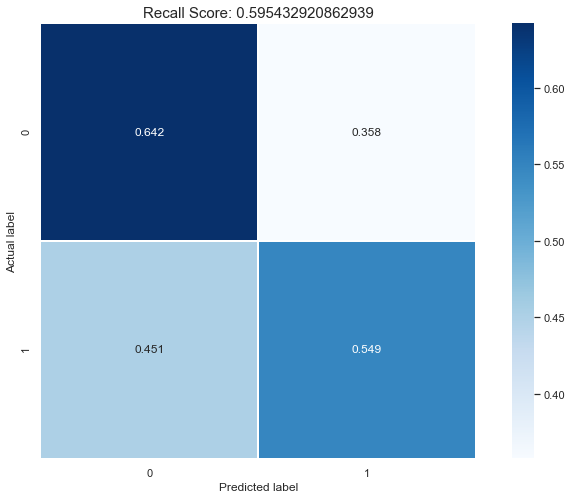

In [128]:
predictions, score = fun.model_test(xgb, X_train, y_train, X_test, y_test)

fun.get_model_performance(predictions, 'Blues', X_test, y_test)

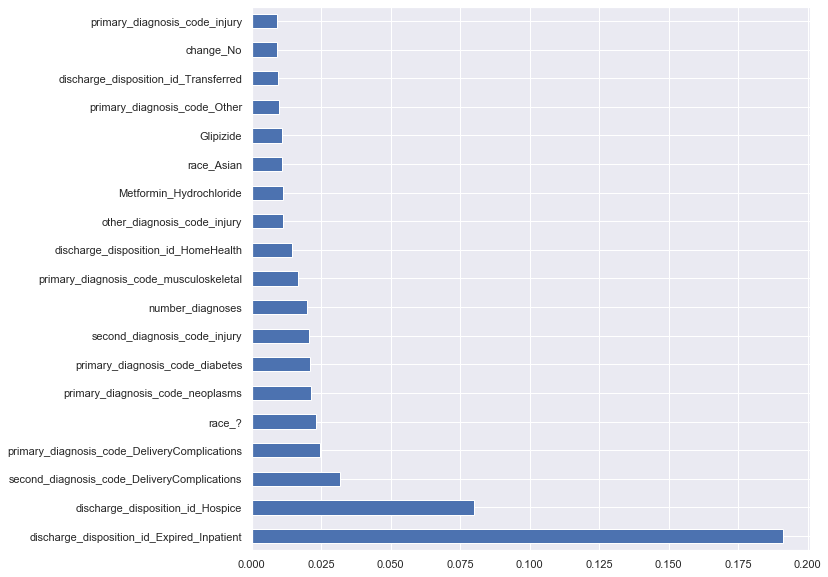

In [129]:
fun.get_important_feats(xgb, X_train)

Confusion Matrix: 
 [[0.57363356 0.42636644]
 [0.49812614 0.50187386]] 

Classification Report: 
                 precision    recall  f1-score   support

Not Readmitted       0.58      0.57      0.57     11014
    Readmitted       0.50      0.50      0.50      9339

      accuracy                           0.54     20353
     macro avg       0.54      0.54      0.54     20353
  weighted avg       0.54      0.54      0.54     20353
 

True Negative: 0.5736335572907209
False Positive: 0.4263664427092791
False Negative: 0.49812613770210945
True Positive: 0.5018738622978905 

Precision score: 0.537727387852369
Recall score: 0.5377537097943057
F1 score : 0.5377380148241169
Accuracy score: 0.5407065297499141


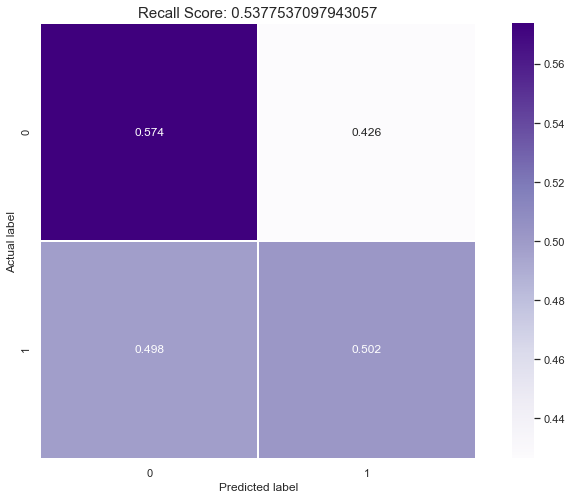

In [147]:
predictions, score = fun.model_test(decision, X_train, y_train, 
                                X_test, y_test)
fun.get_model_performance(predictions, 'Purples', X_test, y_test)

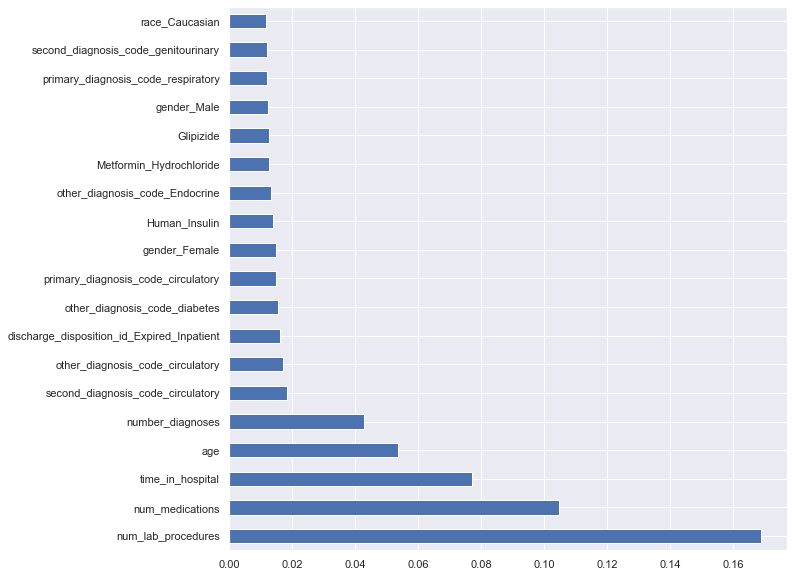

In [148]:
fun.get_important_feats(decision, X_train)

Confusion Matrix: 
 [[0.65952424 0.34047576]
 [0.48442017 0.51557983]] 

Classification Report: 
                 precision    recall  f1-score   support

Not Readmitted       0.62      0.66      0.64     11014
    Readmitted       0.56      0.52      0.54      9339

      accuracy                           0.59     20353
     macro avg       0.59      0.59      0.59     20353
  weighted avg       0.59      0.59      0.59     20353
 

True Negative: 0.6595242418739786
False Positive: 0.34047575812602143
False Negative: 0.4844201734661099
True Positive: 0.5155798265338901 

Precision score: 0.5891957566749884
Recall score: 0.5875520342039344
F1 score : 0.5875028629726051
Accuracy score: 0.5934751633665799


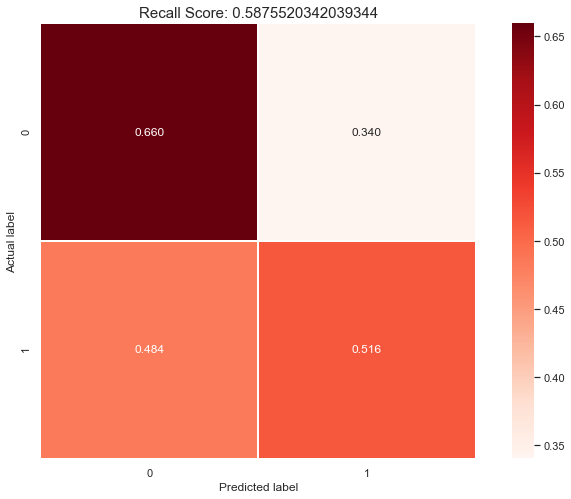

In [141]:
predictions, score = fun.model_test(gbc, X_train, y_train, 
                                X_test, y_test)
fun.get_model_performance(predictions, 'Reds', X_test, y_test)

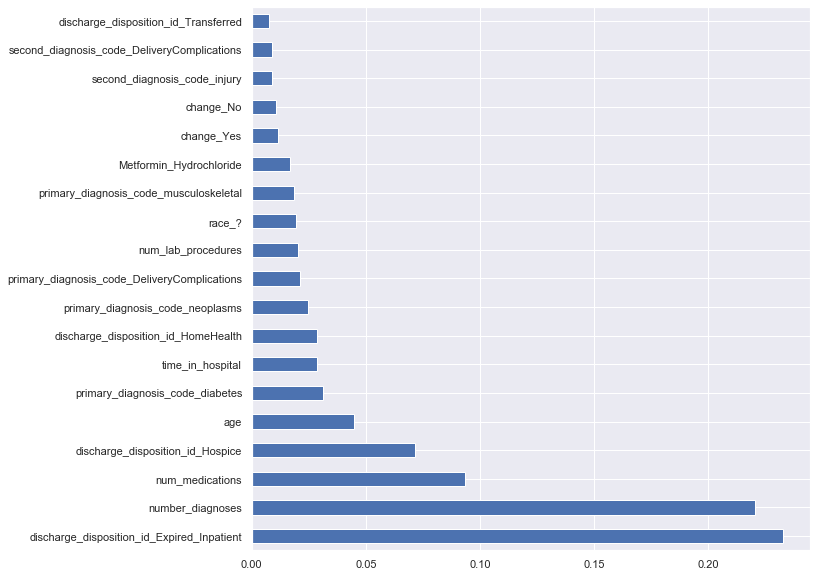

In [142]:
fun.get_important_feats(gbc, X_train)

In [143]:
# predictions, score = fun.model_test(knn, X_train, y_train, 
#                                 X_test, y_test)
# fun.get_model_performance(predictions, 'Pinks', X_test, y_test)

Confusion Matrix: 
 [[0.67305248 0.32694752]
 [0.51954171 0.48045829]] 

Classification Report: 
                 precision    recall  f1-score   support

Not Readmitted       0.60      0.67      0.64     11014
    Readmitted       0.55      0.48      0.51      9339

      accuracy                           0.58     20353
     macro avg       0.58      0.58      0.58     20353
  weighted avg       0.58      0.58      0.58     20353
 

True Negative: 0.6730524786635191
False Positive: 0.32694752133648086
False Negative: 0.5195417068208588
True Positive: 0.48045829317914124 

Precision score: 0.5795876372942879
Recall score: 0.5767553859213301
F1 score : 0.5759155483548289
Accuracy score: 0.5846803910971355


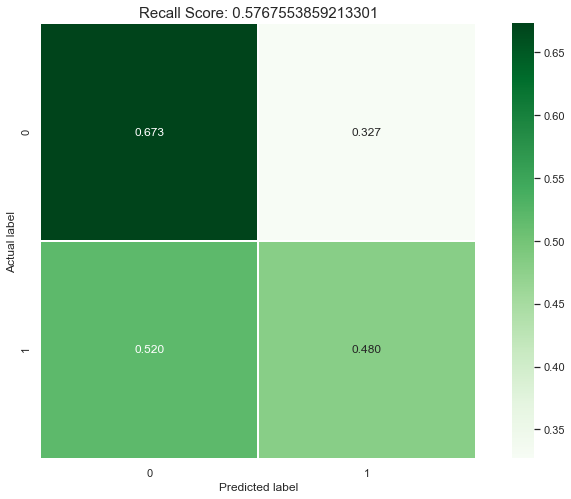

In [149]:
predictions, score = fun.model_test(forest, X_train, y_train, 
                                X_test, y_test)
fun.get_model_performance(predictions, 'Greens', X_test, y_test)

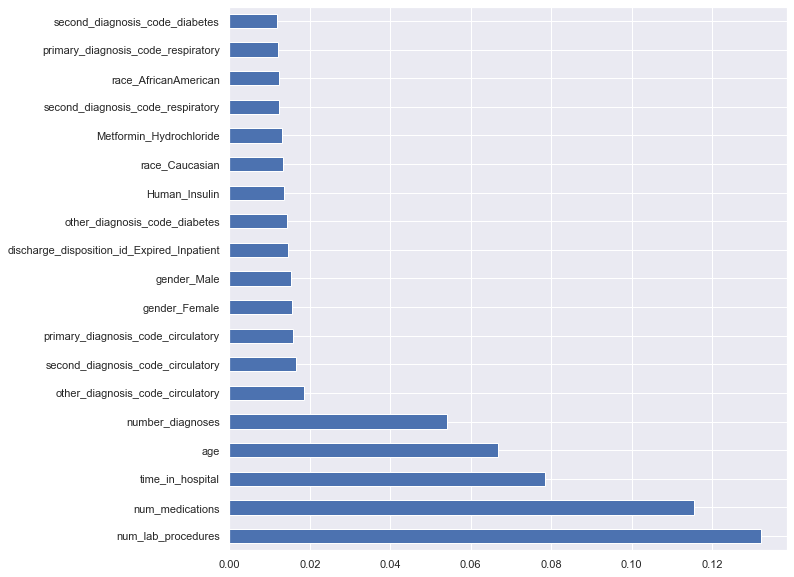

In [150]:
fun.get_important_feats(forest, X_train)

## Deep Learning Model:

### Convert to Tensorflow Dataset:

In [152]:
processed_df = pd.read_csv('processed.csv')
processed_df.head()

,encounter_id,readmitted_binary,race,gender,primary_diagnosis_code,discharge_disposition_id,second_diagnosis_code,other_diagnosis_code,change,age,num_lab_procedures,num_medications,time_in_hospital,number_diagnoses,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide-metformin_Hydrochloride,Human_Insulin,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,12522,0.0,Caucasian,Female,circulatory,Home,circulatory,InfectiousDiseases,Yes,85,68,28,13,8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15738,0.0,Caucasian,Female,circulatory,Transferred,neoplasms,respiratory,Yes,95,33,18,12,8,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,16680,0.0,Caucasian,Male,neoplasms,Home,neoplasms,diabetes,Yes,45,51,8,1,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,28236,1.0,AfricanAmerican,Female,diabetes,Home,circulatory,injury,No,45,47,17,9,9,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,35754,1.0,Caucasian,Male,circulatory,Home,circulatory,diabetes,No,55,31,16,3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [159]:
train, test = train_test_split(processed_df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

65128 train examples
16282 validation examples
20353 test examples


Now it is time to start converting my dataset splits into Tensorflow datasets!

To execute this conversion, I used boilerplate code that I referenced from Tensorflow's tutorial documentation.

https://www.tensorflow.org/tutorials/structured_data/feature_columns


In [160]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
X_train, y_train = fun.df_to_dataset(train, TARGET, batch_size=batch_size)
X_val, y_val = fun.df_to_dataset(val, TARGET, batch_size=batch_size)
X_test, y_test = fun.df_to_dataset(test, TARGET, batch_size=batch_size)

In [168]:
# processed_df

In [167]:
# categorical_features = X_train.select_dtypes('O').columns
# categorical_features

In [166]:
# numerical_features = X_train.select_dtypes(exclude='O')
# numerical_features.columns

In [171]:
categorical_features = ['race', 'gender', 'primary_diagnosis_code', 
                        'discharge_disposition_id',
                       'second_diagnosis_code', 'other_diagnosis_code', 
                        'change']

numerical_features =  ['age', 'num_lab_procedures', 'num_medications',
       'time_in_hospital', 'number_diagnoses', 'Acarbose', 'Glimepiride',
       'Glipizide', 'Glipizide_And_Metformin_Hcl',
       'Glipizide_And_Metformin_Hydrochloride', 'Glyburide',
       'Glyburide-metformin_Hydrochloride', 'Human_Insulin',
       'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide', 'Pioglitazone',
       'Repaglinide', 'Rosiglitazone_Maleate', 'Tolazamide', 'Tolbutamide']

In [172]:
num_pipe = Pipeline([
    ('scaler', 
    StandardScaler())])

cat_pipe = Pipeline([
    ('encoder',
        OneHotEncoder(sparse=False, handle_unknown='ignore'))])

preprocessing = ColumnTransformer(transformers=[
    ('num', num_pipe, numerical_features),
    ('cat', cat_pipe, categorical_features)])
preprocessing

X_train_trans = preprocessing.fit_transform(X_train)
X_test_trans = preprocessing.transform(X_test)
X_val_trans = preprocessing.transform(X_val)


feature_names = preprocessing.named_transformers_['cat'].\
                named_steps['encoder'].get_feature_names(categorical_features).tolist()


X_cols = numerical_features + feature_names
X_train_trans = pd.DataFrame(X_train_trans,columns=X_cols)
X_test_trans = pd.DataFrame(X_test_trans,columns=X_cols)
X_val_trans = pd.DataFrame(X_val_trans, columns=X_cols)
X_train_trans.head()

,age,num_lab_procedures,num_medications,time_in_hospital,number_diagnoses,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide-metformin_Hydrochloride,Human_Insulin,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,race_?,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,primary_diagnosis_code_BloodDiseases,primary_diagnosis_code_CongenitalAnomalies,primary_diagnosis_code_DeliveryComplications,primary_diagnosis_code_Endocrine,primary_diagnosis_code_InfectiousDiseases,primary_diagnosis_code_MentalDisorders,primary_diagnosis_code_NervousSystemDiseases,primary_diagnosis_code_Other,primary_diagnosis_code_SenseOrganDiseases,primary_diagnosis_code_SkinDiseases,primary_diagnosis_code_UnknownSymptoms,primary_diagnosis_code_circulatory,primary_diagnosis_code_diabetes,primary_diagnosis_code_digestive,primary_diagnosis_code_genitourinary,primary_diagnosis_code_injury,primary_diagnosis_code_musculoskeletal,primary_diagnosis_code_neoplasms,primary_diagnosis_code_respiratory,discharge_disposition_id_AMA,discharge_disposition_id_Admitted/Outpatient,discharge_disposition_id_Expired_Elsewhere,discharge_disposition_id_Expired_Inpatient,discharge_disposition_id_Home,discharge_disposition_id_HomeHealth,discharge_disposition_id_Hospice,discharge_disposition_id_NeonatalDischarge,discharge_disposition_id_Transferred,discharge_disposition_id_TransferredMedicare,discharge_disposition_id_TransferredToOutpatient,discharge_disposition_id_Unknown,second_diagnosis_code_BloodDiseases,second_diagnosis_code_CongenitalAnomalies,second_diagnosis_code_DeliveryComplications,second_diagnosis_code_Endocrine,second_diagnosis_code_InfectiousDiseases,second_diagnosis_code_MentalDisorders,second_diagnosis_code_NervousSystemDiseases,second_diagnosis_code_Other,second_diagnosis_code_SenseOrganDiseases,second_diagnosis_code_SkinDiseases,second_diagnosis_code_UnknownSymptoms,second_diagnosis_code_circulatory,second_diagnosis_code_diabetes,second_diagnosis_code_digestive,second_diagnosis_code_genitourinary,second_diagnosis_code_injury,second_diagnosis_code_musculoskeletal,second_diagnosis_code_neoplasms,second_diagnosis_code_respiratory,other_diagnosis_code_BloodDiseases,other_diagnosis_code_CongenitalAnomalies,other_diagnosis_code_DeliveryComplications,other_diagnosis_code_Endocrine,other_diagnosis_code_InfectiousDiseases,other_diagnosis_code_MentalDisorders,other_diagnosis_code_NervousSystemDiseases,other_diagnosis_code_Other,other_diagnosis_code_SenseOrganDiseases,other_diagnosis_code_SkinDiseases,other_diagnosis_code_UnknownSymptoms,other_diagnosis_code_circulatory,other_diagnosis_code_diabetes,other_diagnosis_code_digestive,other_diagnosis_code_genitourinary,other_diagnosis_code_injury,other_diagnosis_code_musculoskeletal,other_diagnosis_code_neoplasms,other_diagnosis_code_respiratory,change_No,change_Yes
0,-0.682624,-0.672086,0.859471,-0.468940,-1.246848,-0.027718,-0.191763,-0.31089,-0.003918,-0.010368,-0.263587,-0.057417,-0.364524,2.038376,-0.011756,-0.069826,-0.177902,-0.110739,-0.156963,-0.015676,-0.014663,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.056570,0.194917,-0.617082,-0.468940,0.817644,-0.027718,-0.191763,-0.31089,-0.003918,-0.010368,-0.263587,-0.057417,-0.364524,2.038376,-0.011756,-0.069826,-0.177902,-0.110739,-0.156963,-0.015676,-0.014663,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [173]:
X_train_trans.shape

(65128, 100)

# Deep Learning Model:

In [174]:
X_train_trans.shape[-1]

100

In [175]:
from sklearn.utils import class_weight

In [179]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [180]:
class_weights = dict(enumerate(class_weights))

In [181]:
class_weights

{0: 0.9277228568986639, 1: 1.084490625104073}

In [313]:
counts = np.bincount(y_train)
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(y_train)
    )
)

weight_for_0 = 1 / counts[0]
weight_for_1 = 1.6 / counts[1]



Number of positive samples in training data: 30027 (46.10% of total)


In [334]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),]


def build_sequential_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Dense(256, activation="relu"),
#         tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')])
    return model

def build_model(X_train, y_train, X_val, y_val, 
                optimizer=tf.keras.optimizers.Adam(1e-2), 
                epochs=5, build_fn=build_sequential_model):
    model = build_fn()
    model.compile(
        optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=METRICS)
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                verbose=1,
                                patience=5,
                                mode='max',
                                restore_best_weights=False) 

    class_weight = {0: weight_for_0, 1: weight_for_1}
#     class_weight = class_weights
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        callbacks=early_stop,
                        epochs=epochs, class_weight=class_weight, 
                        batch_size=248)
    return model, history 

In [315]:
diabetes_model, history = build_model(X_train_trans, y_train, 
                                      X_val_trans, y_val,  
                                                    epochs=30)

Epoch 1/30
263/263 [==============================] - 2s 4ms/step - loss: 2.6447e-05 - accuracy: 0.4945 - precision: 0.4733 - recall: 0.9114 - auc: 0.5681 - val_loss: 0.7308 - val_accuracy: 0.4953 - val_precision: 0.4762 - val_recall: 0.9730 - val_auc: 0.6193
Epoch 2/30
263/263 [==============================] - 1s 3ms/step - loss: 2.5664e-05 - accuracy: 0.5313 - precision: 0.4946 - recall: 0.9154 - auc: 0.6190 - val_loss: 0.7144 - val_accuracy: 0.5268 - val_precision: 0.4924 - val_recall: 0.9294 - val_auc: 0.6214
Epoch 3/30
263/263 [==============================] - 1s 3ms/step - loss: 2.5307e-05 - accuracy: 0.5371 - precision: 0.4992 - recall: 0.9104 - auc: 0.6301 - val_loss: 0.6961 - val_accuracy: 0.5421 - val_precision: 0.5013 - val_recall: 0.9127 - val_auc: 0.6282
Epoch 4/30
263/263 [==============================] - 1s 3ms/step - loss: 2.5125e-05 - accuracy: 0.5435 - precision: 0.5019 - recall: 0.9141 - auc: 0.6403 - val_loss: 0.7163 - val_accuracy: 0.5198 - val_precision: 0.4888

## Model Performance:

In [316]:
metrics_diab = diabetes_model.evaluate(X_test_trans, y_test)
print("Metrics", metrics_diab)

637/637 [==============================] - 1s 967us/step - loss: 0.6941 - accuracy: 0.5405 - precision: 0.5009 - recall: 0.9063 - auc: 0.6292
Metrics [0.6940991282463074, 0.5404608845710754, 0.5009422898292542, 0.9063398838043213, 0.6292486190795898]


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


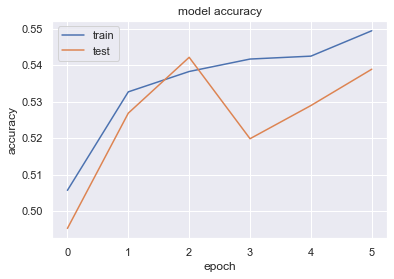

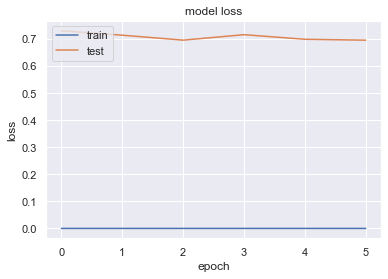

In [317]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [318]:
preds = diabetes_model.predict(X_test_trans).round()

In [319]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, preds)
cnf_matrix

array([[2494, 8474],
       [ 879, 8506]])

In [320]:
cnf_matrix = metrics.confusion_matrix(y_test, preds, normalize='true')
cnf_matrix

array([[0.22738877, 0.77261123],
       [0.0936601 , 0.9063399 ]])

In [321]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.74      0.23      0.35     10968
         1.0       0.50      0.91      0.65      9385

    accuracy                           0.54     20353
   macro avg       0.62      0.57      0.50     20353
weighted avg       0.63      0.54      0.48     20353



## Feature Selection:

In [322]:
X_train_trans.head()

,age,num_lab_procedures,num_medications,time_in_hospital,number_diagnoses,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide-metformin_Hydrochloride,Human_Insulin,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,race_?,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,primary_diagnosis_code_BloodDiseases,primary_diagnosis_code_CongenitalAnomalies,primary_diagnosis_code_DeliveryComplications,primary_diagnosis_code_Endocrine,primary_diagnosis_code_InfectiousDiseases,primary_diagnosis_code_MentalDisorders,primary_diagnosis_code_NervousSystemDiseases,primary_diagnosis_code_Other,primary_diagnosis_code_SenseOrganDiseases,primary_diagnosis_code_SkinDiseases,primary_diagnosis_code_UnknownSymptoms,primary_diagnosis_code_circulatory,primary_diagnosis_code_diabetes,primary_diagnosis_code_digestive,primary_diagnosis_code_genitourinary,primary_diagnosis_code_injury,primary_diagnosis_code_musculoskeletal,primary_diagnosis_code_neoplasms,primary_diagnosis_code_respiratory,discharge_disposition_id_AMA,discharge_disposition_id_Admitted/Outpatient,discharge_disposition_id_Expired_Elsewhere,discharge_disposition_id_Expired_Inpatient,discharge_disposition_id_Home,discharge_disposition_id_HomeHealth,discharge_disposition_id_Hospice,discharge_disposition_id_NeonatalDischarge,discharge_disposition_id_Transferred,discharge_disposition_id_TransferredMedicare,discharge_disposition_id_TransferredToOutpatient,discharge_disposition_id_Unknown,second_diagnosis_code_BloodDiseases,second_diagnosis_code_CongenitalAnomalies,second_diagnosis_code_DeliveryComplications,second_diagnosis_code_Endocrine,second_diagnosis_code_InfectiousDiseases,second_diagnosis_code_MentalDisorders,second_diagnosis_code_NervousSystemDiseases,second_diagnosis_code_Other,second_diagnosis_code_SenseOrganDiseases,second_diagnosis_code_SkinDiseases,second_diagnosis_code_UnknownSymptoms,second_diagnosis_code_circulatory,second_diagnosis_code_diabetes,second_diagnosis_code_digestive,second_diagnosis_code_genitourinary,second_diagnosis_code_injury,second_diagnosis_code_musculoskeletal,second_diagnosis_code_neoplasms,second_diagnosis_code_respiratory,other_diagnosis_code_BloodDiseases,other_diagnosis_code_CongenitalAnomalies,other_diagnosis_code_DeliveryComplications,other_diagnosis_code_Endocrine,other_diagnosis_code_InfectiousDiseases,other_diagnosis_code_MentalDisorders,other_diagnosis_code_NervousSystemDiseases,other_diagnosis_code_Other,other_diagnosis_code_SenseOrganDiseases,other_diagnosis_code_SkinDiseases,other_diagnosis_code_UnknownSymptoms,other_diagnosis_code_circulatory,other_diagnosis_code_diabetes,other_diagnosis_code_digestive,other_diagnosis_code_genitourinary,other_diagnosis_code_injury,other_diagnosis_code_musculoskeletal,other_diagnosis_code_neoplasms,other_diagnosis_code_respiratory,change_No,change_Yes
0,-0.682624,-0.672086,0.859471,-0.468940,-1.246848,-0.027718,-0.191763,-0.31089,-0.003918,-0.010368,-0.263587,-0.057417,-0.364524,2.038376,-0.011756,-0.069826,-0.177902,-0.110739,-0.156963,-0.015676,-0.014663,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.056570,0.194917,-0.617082,-0.468940,0.817644,-0.027718,-0.191763,-0.31089,-0.003918,-0.010368,-0.263587,-0.057417,-0.364524,2.038376,-0.011756,-0.069826,-0.177902,-0.110739,-0.156963,-0.015676,-0.014663,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [329]:
# X_train_trans.columns

In [325]:
X_train_trans.drop(['num_lab_procedures', 'num_medications', 
     'race_AfricanAmerican', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Other', 'gender_Female', 'gender_Male',
       'primary_diagnosis_code_BloodDiseases',
       'primary_diagnosis_code_CongenitalAnomalies',
       'primary_diagnosis_code_DeliveryComplications',
       'primary_diagnosis_code_Endocrine',
       'primary_diagnosis_code_InfectiousDiseases',
       'primary_diagnosis_code_MentalDisorders',
       'primary_diagnosis_code_NervousSystemDiseases',
       'primary_diagnosis_code_Other',
       'primary_diagnosis_code_SenseOrganDiseases',
       'primary_diagnosis_code_SkinDiseases',
       'primary_diagnosis_code_UnknownSymptoms',
       'primary_diagnosis_code_neoplasms',               
       'second_diagnosis_code_BloodDiseases',
       'second_diagnosis_code_CongenitalAnomalies',
       'second_diagnosis_code_DeliveryComplications',
       'second_diagnosis_code_Endocrine',
       'second_diagnosis_code_InfectiousDiseases',
       'second_diagnosis_code_MentalDisorders',
       'second_diagnosis_code_NervousSystemDiseases',
       'second_diagnosis_code_Other',
       'second_diagnosis_code_SenseOrganDiseases',
       'second_diagnosis_code_SkinDiseases',
       'second_diagnosis_code_UnknownSymptoms',  
       'second_diagnosis_code_neoplasms',
       'other_diagnosis_code_BloodDiseases',
       'other_diagnosis_code_CongenitalAnomalies',
       'other_diagnosis_code_DeliveryComplications',
       'other_diagnosis_code_Endocrine',
       'other_diagnosis_code_InfectiousDiseases',
       'other_diagnosis_code_MentalDisorders',
       'other_diagnosis_code_NervousSystemDiseases',
       'other_diagnosis_code_Other', 'other_diagnosis_code_SenseOrganDiseases',
       'other_diagnosis_code_SkinDiseases',
       'other_diagnosis_code_UnknownSymptoms',
       'other_diagnosis_code_circulatory', 'other_diagnosis_code_diabetes',
       'other_diagnosis_code_digestive', 'other_diagnosis_code_genitourinary',
       'other_diagnosis_code_injury', 'other_diagnosis_code_musculoskeletal',
       'other_diagnosis_code_neoplasms', 'other_diagnosis_code_respiratory',
       'change_No', 'change_Yes'], axis=1, inplace=True)

In [342]:
def build_sequential_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Dense(256, activation="relu"),
#         tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')])
    return model

def build_model(X_train, y_train, X_val, y_val, 
                optimizer=tf.keras.optimizers.Adam(1e-2), 
                epochs=5, build_fn=build_sequential_model):
    model = build_fn()
    model.compile(
        optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=METRICS)
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                verbose=1,
                                patience=5,
                                mode='max',
                                restore_best_weights=False) 

    class_weight = {0: weight_for_0, 1: weight_for_1}
#     class_weight = class_weights
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        callbacks=early_stop,
                        epochs=epochs, class_weight=class_weight, 
                        batch_size=248)
    return model, history 

In [343]:
diabetes_model, history = build_model(X_train_trans, y_train, 
                                      X_val_trans, y_val,  
                                                    epochs=30)

Epoch 1/30
263/263 [==============================] - 2s 4ms/step - loss: 2.6661e-05 - accuracy: 0.4998 - precision: 0.4787 - recall: 0.9426 - auc: 0.5830 - val_loss: 0.7278 - val_accuracy: 0.4945 - val_precision: 0.4748 - val_recall: 0.9298 - val_auc: 0.5959
Epoch 2/30
263/263 [==============================] - 1s 2ms/step - loss: 2.6013e-05 - accuracy: 0.5107 - precision: 0.4849 - recall: 0.9329 - auc: 0.5998 - val_loss: 0.7034 - val_accuracy: 0.5367 - val_precision: 0.4980 - val_recall: 0.8754 - val_auc: 0.6075
Epoch 3/30
263/263 [==============================] - 1s 2ms/step - loss: 2.5665e-05 - accuracy: 0.5182 - precision: 0.4879 - recall: 0.9263 - auc: 0.6082 - val_loss: 0.7170 - val_accuracy: 0.5107 - val_precision: 0.4838 - val_recall: 0.9507 - val_auc: 0.6104
Epoch 4/30
263/263 [==============================] - 1s 2ms/step - loss: 2.5532e-05 - accuracy: 0.5219 - precision: 0.4903 - recall: 0.9351 - auc: 0.6130 - val_loss: 0.7292 - val_accuracy: 0.5081 - val_precision: 0.4825

637/637 [==============================] - 1s 813us/step - loss: 0.7103 - accuracy: 0.5143 - precision: 0.4865 - recall: 0.9565 - auc: 0.6144
Metrics [0.7102549076080322, 0.5143222212791443, 0.48645278811454773, 0.9565263986587524, 0.6144285798072815]
dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


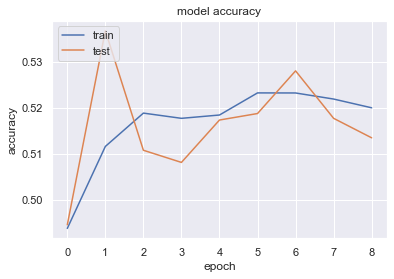

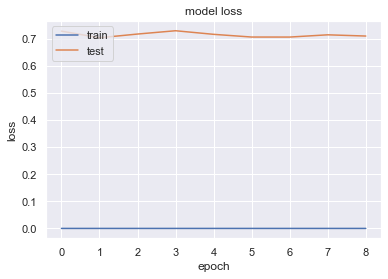

In [344]:
metrics_diab = diabetes_model.evaluate(X_test_trans, y_test)
print("Metrics", metrics_diab)

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [345]:
preds = diabetes_model.predict(X_test_trans).round()

In [352]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, preds)
cnf_matrix

array([[1491, 9477],
       [ 408, 8977]])

In [347]:
cnf_matrix = metrics.confusion_matrix(y_test, preds, normalize='true')
cnf_matrix

array([[0.13594092, 0.86405908],
       [0.04347363, 0.95652637]])

In [348]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.79      0.14      0.23     10968
         1.0       0.49      0.96      0.64      9385

    accuracy                           0.51     20353
   macro avg       0.64      0.55      0.44     20353
weighted avg       0.65      0.51      0.42     20353



In [356]:
recall = recall_score(y_test, preds, average='binary')

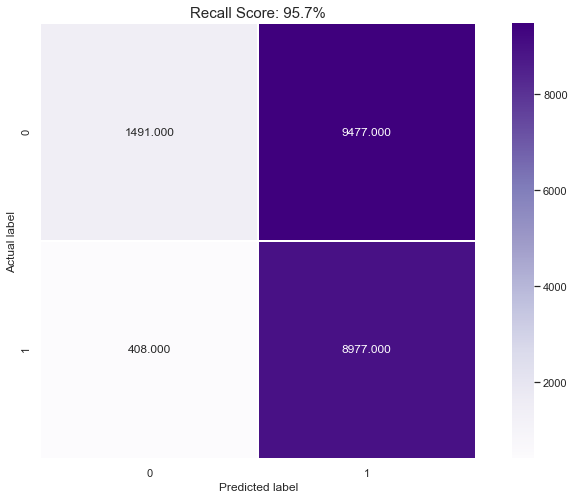

In [362]:
plt.figure(figsize=(13,8))
sns.heatmap(cnf_matrix, 
        annot=True, fmt=".3f", linewidths=.5, square = True, 
                cmap = 'Purples');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = (f'Recall Score: {recall.round(3)*100}%')
plt.title(all_sample_title, size = 15);

> Using the binary lablels array, I can make in a dataframe to better visualize. 
- The Aequitas toolkit requires a dataframe.
- Predictions will be mapped to a binary label 
- predictions = score
- actual = label_value

In [363]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": y_test}
prob_df = pd.DataFrame(prob_outputs)

In [364]:
prob_df

,pred,actual_value
81496,1.0,0.0
43603,0.0,0.0
27415,1.0,0.0
89473,0.0,0.0
10047,0.0,1.0
...,...,...
29740,1.0,0.0
94795,1.0,1.0
74637,1.0,1.0
22542,0.0,0.0


In [366]:
def add_predictions(df_test, pred_np,  y_test):
    df_test['score'] = pred_np
    df_test['label_value'] = y_test
    return df_test

In [368]:
predictions_test_df = add_predictions(X_test, preds, 
                                           y_test)                                

In [369]:
predictions_test_df

,encounter_id,race,gender,primary_diagnosis_code,discharge_disposition_id,second_diagnosis_code,other_diagnosis_code,change,age,num_lab_procedures,num_medications,time_in_hospital,number_diagnoses,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide-metformin_Hydrochloride,Human_Insulin,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,score,label_value
81496,252552534,Caucasian,Female,genitourinary,Transferred,genitourinary,Endocrine,Yes,85,43,16,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0
43603,134674956,Caucasian,Male,neoplasms,Hospice,neoplasms,neoplasms,Yes,75,44,11,3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0
27415,89779590,Caucasian,Female,injury,Transferred,genitourinary,genitourinary,No,75,57,8,5,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0
89473,289066956,Caucasian,Female,musculoskeletal,Home,circulatory,UnknownSymptoms,No,65,23,7,3,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0
10047,42942462,AfricanAmerican,Female,genitourinary,Home,injury,respiratory,No,75,27,17,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29740,96821430,Caucasian,Female,digestive,Home,digestive,digestive,No,65,15,19,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0
94795,352588214,Caucasian,Female,respiratory,Home,respiratory,circulatory,No,75,21,12,3,8,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.0,1.0
74637,222488976,Caucasian,Male,respiratory,Home,MentalDisorders,circulatory,Yes,75,56,17,3,9,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1.0,1.0
22542,77650902,Caucasian,Female,circulatory,Unknown,circulatory,diabetes,No,75,19,8,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0


In [370]:
predictions_test_df[['time_in_hospital', 
                                               'score', 'label_value']].head()

,time_in_hospital,score,label_value
81496,1,1.0,0.0
43603,3,0.0,0.0
27415,5,1.0,0.0
89473,3,0.0,0.0
10047,6,0.0,1.0


## Model Evaluation Metrics 

To evaluate the model I can use the binary labels with classification metrics. 

- ROC AUC
- F1 score(weighted)
- class precision 
- recall scores 

In [371]:
confusion_matrix(prob_df['actual_value'], 
                                              prob_df['pred'])

array([[1491, 9477],
       [ 408, 8977]])

In [372]:
print(classification_report(prob_df['actual_value'], 
                                              prob_df['pred']))

              precision    recall  f1-score   support

         0.0       0.79      0.14      0.23     10968
         1.0       0.49      0.96      0.64      9385

    accuracy                           0.51     20353
   macro avg       0.64      0.55      0.44     20353
weighted avg       0.65      0.51      0.42     20353



In [373]:
roc_auc = roc_auc_score(prob_df['actual_value'], 
                                              prob_df['pred'])
f1 = f1_score(prob_df['actual_value'], 
                                              prob_df['pred'], 
                                                      average='weighted')
precision = precision_score(prob_df['actual_value'], 
                                              prob_df['pred'], 
                                                      average='weighted')
recall = recall_score(prob_df['actual_value'], 
                                              prob_df['pred'], 
                                                          average='micro')

print(f'ROC AUC Score: {roc_auc}')
print(f'F1 Score: {f1}')
print(f'Precision Score: {precision}')
print(f'Recall Score: {recall}')

ROC AUC Score: 0.5462336454536022
F1 Score: 0.422271631992054
Precision Score: 0.6474173639756935
Recall Score: 0.5143222129415811


ROC AUC Score: 0.5462336454536022


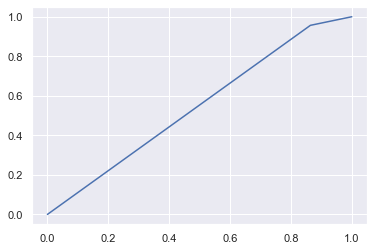

In [374]:
print(f'ROC AUC Score: {roc_auc}')
roc = roc_curve(prob_df['actual_value'], 
                                              prob_df['pred'])
plt.plot(roc[0], roc[1])
plt.show()

Precision-recall trade-off:

The more the model tries to eliminate false positives (increase precision), the more the model will error on the side of false negatives.
- Forced to classify as "False" at the possibility that it might be False. 
- This means that sometimes actual positives will be classified as "False" = False Negative.
- Minimizing FPs = higher FNs.

The more the model tries to minimize False Negatives (increase recall), the more it is forced to classify as positive those records that have the possibility of being positive, even though they in fact are Negative. 
- Minimizing FNs = FPs increase   

Precision and recall are both right at 0.75. 
- This shows good trade-off!
- Definitely has room for improvement.

Precison score is the measure of true identified result while Recall score measure the false identified result. In our problem, we need to identified patients who satisfy our criteria as well as we don't want to interept patients who can't be part of our testing due to low hospitalize time.

So, both precison and recall are important measure.

For more improvement of model performance, can add more complex layers in model architecture with data.

F1-Score:
The harmonic mean of precision and recall
- It is better than using a simple average, because if one of two is small and the other large, F1-score will reflect it better than an average.
- The weighted F1-score average is also 0.75.

ROC-AUC:
A good model (something that has actually learned something from the data), would make it possible to find internal parameters/threshold where False Positive rate can be minimized while keeping False Negative rate comparatively low. 
This can be measured with AUC (Area Under the Curve)
- Here the score is 0.73. 
- Not great but larger than 0.5.


Parameter Optimizing:
- Smaller learning rate
- Validation loss bounces back and forth (possibly around local minima?)

Precision-recall tradeoff? (model optimization)

Future Work?

# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Aequitas Bias Toolkit:

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [375]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = predictions_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


## Group Selection:

Here I can chose the reference group for analysis.

In [376]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


## Race and Gender Bias Analysis for Patient Selection

To check for significant bias in the model cross race and gender:
- Plot metrics that are important for patient selection (with race and gender).
- Check for significant bias in the model across any of the groups.

In [377]:
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,18454,race,?,269,195,169,38,157,100,138,326,464,20353
1,0,binary 0/1,18454,race,AfricanAmerican,3350,369,1766,88,281,1584,1672,2047,3719,20353
2,0,binary 0/1,18454,race,Asian,123,10,74,1,9,49,50,83,133,20353
3,0,binary 0/1,18454,race,Caucasian,14138,1237,7159,262,975,6979,7241,8134,15375,20353
4,0,binary 0/1,18454,race,Hispanic,343,45,184,9,36,159,168,220,388,20353
5,0,binary 0/1,18454,race,Other,231,43,125,10,33,106,116,158,274,20353
6,0,binary 0/1,18454,gender,Female,9990,976,5054,225,751,4936,5161,5805,10966,20353
7,0,binary 0/1,18454,gender,Male,8464,923,4423,183,740,4041,4224,5163,9387,20353


In [378]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race,?,0.72,0.48,0.19,0.63,0.52,0.28,0.81,0.37,0.01,0.58,0.30
1,race,AfricanAmerican,0.95,0.14,0.24,0.53,0.86,0.05,0.76,0.47,0.18,0.90,0.45
2,race,Asian,0.98,0.11,0.10,0.60,0.89,0.02,0.90,0.40,0.01,0.92,0.38
3,race,Caucasian,0.96,0.12,0.21,0.51,0.88,0.04,0.79,0.49,0.77,0.92,0.47
4,race,Hispanic,0.95,0.16,0.20,0.54,0.84,0.05,0.80,0.46,0.02,0.88,0.43
5,race,Other,0.91,0.21,0.23,0.54,0.79,0.09,0.77,0.46,0.01,0.84,0.42
6,gender,Female,0.96,0.13,0.23,0.51,0.87,0.04,0.77,0.49,0.54,0.91,0.47
7,gender,Male,0.96,0.14,0.20,0.52,0.86,0.04,0.80,0.48,0.46,0.90,0.45


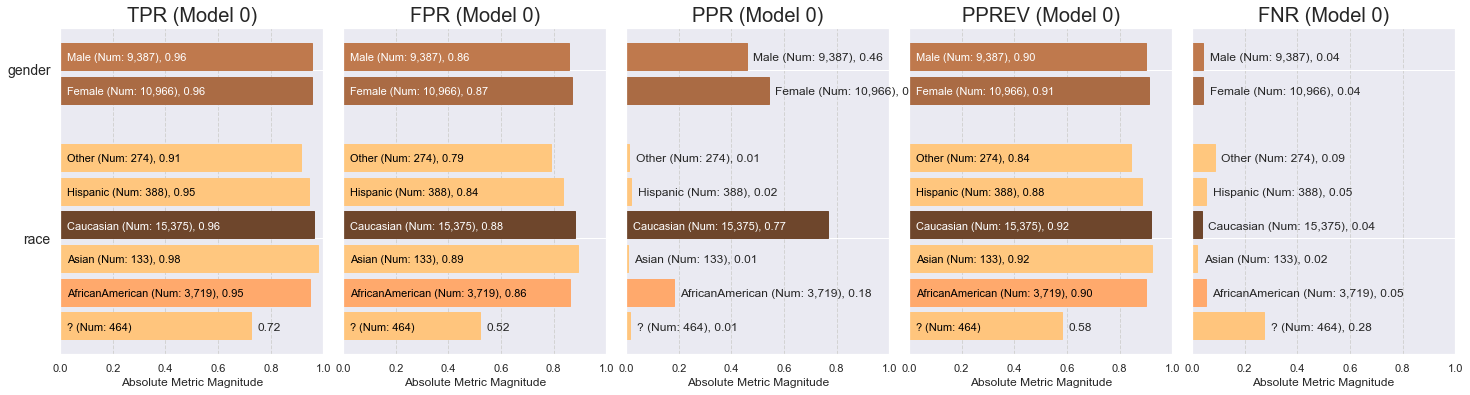

<Figure size 432x288 with 0 Axes>

In [379]:
p = aqp.plot_group_metric_all(xtab, metrics=['tpr', 'fpr', 'ppr', 
                                             'pprev', 'fnr'], ncols=5)

From the visualizations above, we can see, the model shows no noticeable bias in gender (between male and female groups), and almost no bias in race, EXCEPT for PPR (Positive Predictive Rate, or precision).

PPR looks very much higher for Caucasian group (much higher precision), which also means much lower portion of False Positives among positive predictions. 

This means that among the patients selected by our model for this drug program, the selected Caucasian people have a much higher chance of being actually fit (the right choice) for the program as compared to other groups, especially Hispanics or Asians, which will have a higher probability of NOT being a good fit for the program. 

This can be a useful piece of info to know in advance when working with this model.

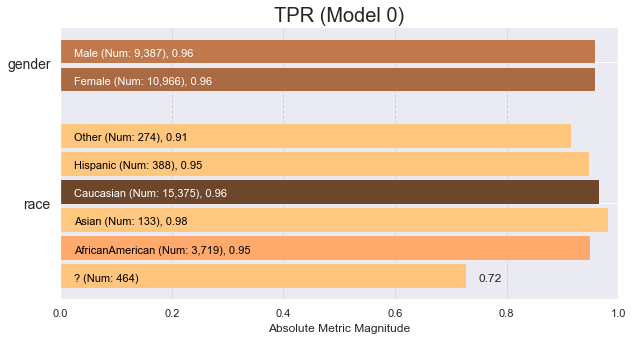

In [380]:
tpr = aqp.plot_group_metric(clean_xtab, 'tpr')

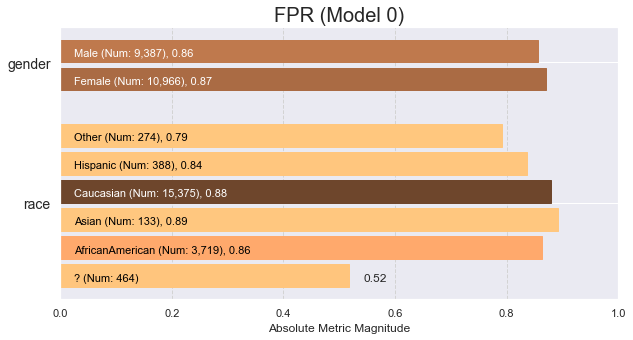

In [381]:
fpr = aqp.plot_group_metric(clean_xtab, 'fpr')

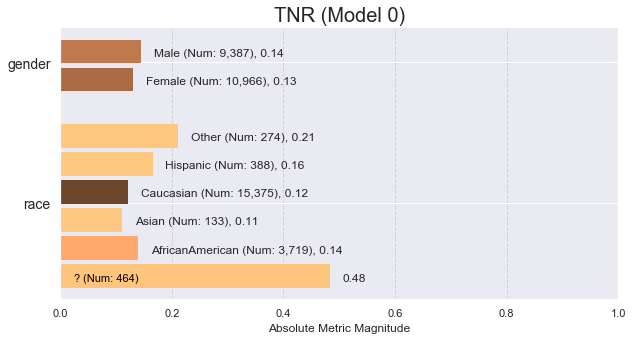

In [382]:
tnr = aqp.plot_group_metric(clean_xtab, 'tnr')

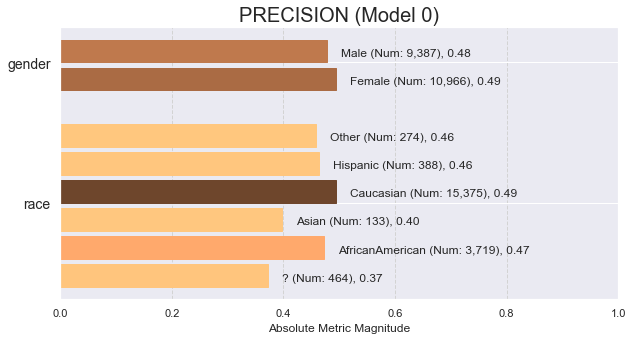

In [383]:
precision = aqp.plot_group_metric(clean_xtab, 'precision')

There isn't any significant bias in the model for either race or gender.

## Fairness Analysis: 

Let's look at the visualization of the fairness evaluation for gender and race to analyze whether there is disparity.

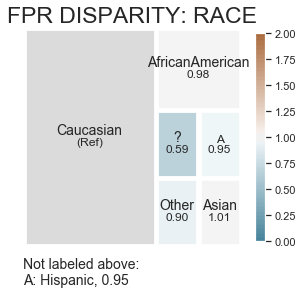

In [384]:
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                   attribute_name='race')


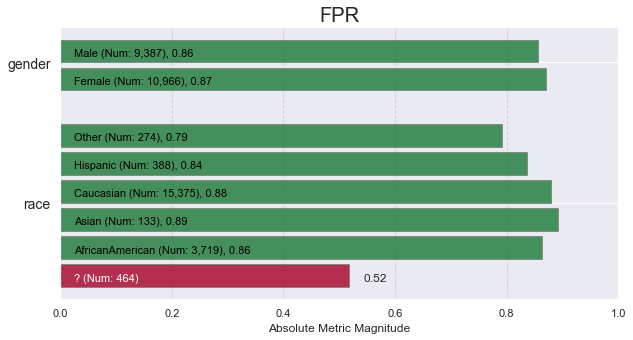

In [385]:
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

Caucasion is the reference (1) for the probability of being indentified falsely. 
- The other races are ...

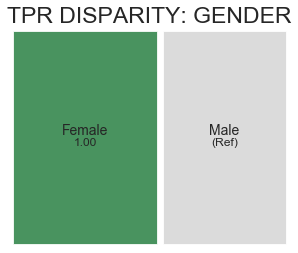

In [386]:
tpr_disparity_fairness = aqp.plot_fairness_disparity(fdf, group_metric='tpr',
                                                     attribute_name='gender')

In [387]:
# Reference group fairness plot

## Model Interpretability with Shapley Values

- Using Open Source Library Shap - https://github.com/slundberg/shap
- Developed by Su-In Lee's lab at the University of Washington, and Microsoft Research

In [388]:
# adapted from https://github.com/kweinmeister/notebooks/blob/master/tensorflow-shap-college-debt.ipynb
# https://towardsdatascience.com/understand-how-your-tensorflow-model-is-making-predictions-d0b3c7e88500

In [389]:
import shap
shap.initjs()

### Train Model without Dense Features

Steps:

- Use Kmeans clustering to summarize data. As we mentioned earlier 
- The issue with Shapley can be the computation time and a way to reduce this is to cluster the features with Kmeans. 


In [ ]:
num

In [ ]:
def build_shap_model(num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(100, activation='relu', 
                              input_shape=[num_features]),
        tf.keras.layers.Dense(100, activation='relu'),
#         tf.keras.layers.Dropout(0.35),
        tf.keras.layers.Dense(1)]
#         tf.keras.layers.Dropout(0.35),
#         tf.keras.layers.Dense(1, activation='sigmoid')])
#     return model

# def build_shap_model(num_features):
#     model = tf.keras.Sequential([
#     tf.keras.layers.Dense(64, activation='relu', input_shape=[num_features]),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(1)
#     ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='val_loss',
                optimizer=optimizer,
                metrics=metrics)
    return model

In [ ]:
shap_num_features = len(numerical_feature_list)
shap_feature_columns =  tf_numerical_feature_list
shap_feature_layer = tf.keras.layers.DenseFeatures(shap_feature_columns)
shap_model = build_shap_model(shap_num_features)

In [ ]:
EPOCHS = 1000
early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=10)     
shap_history = shap_model.fit(normed_train_data, train_labels,  
                        callbacks=[early_stop], epochs=EPOCHS, verbose=1)

### Use KMeans to Summarize Dataset

In [ ]:
df_train_normed_summary = shap.kmeans(normed_train_data.values, 25)

In [ ]:
# Instantiate an explainer with the model predictions and training data summary
explainer = shap.KernelExplainer(shap_model.predict, 
                                 df_train_normed_summary)

In [ ]:
# may need to install ipywidgets to see status visualization
'''
pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension
'''

In [ ]:
# Extract Shapley values from the explainer
shap_values = explainer.shap_values(normed_train_data.values)

In [ ]:
# Summarize the Shapley values in a plot
shap.summary_plot(shap_values[0], normed_train_data)

> Explanation of Feature Importance Visual:
- The y-axis shows the feature importance scale from top to bottom.
- The sorted order of features gives the relative importance ranking of features ... is the most important feature
- The x-axis = see the Shapley values impact on model output
- Feature values are either red, which stands for high values 
- or blue which is for low values


In [ ]:
INSTANCE_NUM = 0
shap.force_plot(explainer.expected_value[0], 
                shap_values[0][INSTANCE_NUM], 
                normed_train_data.iloc[INSTANCE_NUM,:])

Single point visualization:
- This shows what features change the base value towards zero 
- The base value is the average model output over the training set
- The features in red are pushing the label to a higher value 
- The features in blue are pushing lower


In [ ]:
# Plot the SHAP values for multiple instances
NUM_ROWS = 10
shap.force_plot(explainer.expected_value[0], 
                shap_values[0][0:NUM_ROWS], 
                normed_train_data.iloc[0:NUM_ROWS])

Larger Sample:
- expand it to a sample of 10 points